In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from sklearn.metrics import confusion_matrix

In [11]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

### Funciones útiles

In [12]:
def id_to_position(x, learner, user = False):
    """ Funcion que toma un userId o movieId y busca su posicion en la lista de classes del learner
    """
    if user:
        classes = learner.data.dataset.x.classes['userId']
    else:
        classes = learner.data.dataset.x.classes['movieId']
    try:
        res = int(np.where(classes == str(x))[0][0])
    except:
        res = None
    return res

In [13]:
class TestCallback(Callback):
    def __init__(self, learn: Learner):
        super().__init__()
        self.learn = learn
    
    def on_train_begin(self, **kwargs:Any)->None:
        super().on_train_begin(**kwargs)
        self.n_iters = 0
        #pdb.set_trace()
        
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        self.n_iters += 1
        print("testCb: Fin de la epoch " ,self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
            
    def on_train_end(self, **kwargs:Any)->None:
        print(" ")
        print("TestCallBack: ¡Gracias por todo! Cantidad de epochs corridas: ", self.n_iters)

In [14]:
class EarlyStoppingFede(callbacks.TrackerCallback):
    valid_track = []
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', min_delta:int=0, patience:int=0):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.min_delta,self.patience = min_delta,patience
        if self.operator == np.less:  self.min_delta *= -1

    def on_train_begin(self, **kwargs:Any)->None:
        "Initialize inner arguments."
        self.wait = 0
        self.valid_track = []
        super().on_train_begin(**kwargs)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe stop training."
        current = self.get_monitor_value()
        if current is None: return
        self.valid_track.append(current)
        print("")
        print("current: ", current)
        print("current - delta: ", current - self.min_delta)
        print("best: ", self.best)
        if self.operator(current - self.min_delta, self.best):
            self.best,self.wait = current,0
            print("Esto viene bien...")
        else:
            self.wait += 1
            print("Hmmmm... sigamos un poco...")
            if self.wait > self.patience:
                print(f'Epoch {epoch}: early stopping')
                print("Bueno, ya!")
                return {"stop_training":True}
            
    def on_train_end(self, **kwargs:Any)->None:
        "Useful for cleaning up things and saving files/models."
        print(" ")
        plt.plot(self.valid_track)
        plt.grid()
        plt.xlabel("Epoch")
        plt.ylabel("Validation loss")
        print(self.valid_track)

In [15]:
def print_metrics(confusion, total_size):
        
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    p_v = confusion[1][1]/(confusion[0][1]+confusion[1][1])
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    f1 = 2*(p*recall/(p+recall))
    
    print('Number of test values: ', n)
    print('Subsample size percentage: ', n*100/total_size)
    print('Overall Accuracy: ', p*100)
    print('Accuracy on Cancelado: ', p_c*100)
    print('Accuracy on Vigente: ', p_v*100)
    print('Recall: ', recall)
    print('f1-score: ', f1)

In [16]:
def create_result_df(y_pred, y_test, y_pred_proba):
    trust = [x.max() for x in y_pred_proba]
    cancelado_proba = y_pred_proba[:, 0]
    preds_df = pd.DataFrame()
    preds_df['idclientecrm'] = list(y_test[:,0].ravel())
    #preds_df['y_test'] = list(y_test.reshape(1, -1)[0])
    preds_df['y_test'] = list(y_test[:,1].ravel())
    preds_df['y_pred'] = y_pred
    preds_df['trust'] = trust
    preds_df['Cancelado probability'] = cancelado_proba
    preds_df['Correct'] = np.where(preds_df['y_test'] == preds_df['y_pred'], True, False)
    return preds_df.sort_values(by = 'trust', ascending = False).reset_index(drop = True)

In [17]:
def plot_confussion_matrix(confusion, strategy = 'Random Forest Classifier'):
    plt.figure(figsize = (4,3))
    classes = ['Cancelado', 'Vigente']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 15},fmt="d")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    ax.set_yticklabels(classes, rotation=0)
    ax.set_xticklabels(classes, rotation=0)
    plt.title('Confusion Matrix for '+strategy, fontweight="bold")

In [18]:
def smooth_curve(arreglo, window = 10):
    b = []
    aux = []
    for i, k in enumerate(arreglo):
        aux.append(k)
        if len(aux) > window : aux.pop(0)
        b.append(np.array(aux).mean())
    return np.array(b)

In [19]:
def fit_n_estimators(X_train, y_train, X_test, y_test, value, iterations = 5, scope = 1):
    n = iterations
    n_est = []
    metric = []
    for i in range(-n+1, n):
        trees = round(value*(1-scope*i/n))
        if trees > 0:
            n_est.append(round(value*(1-scope*i/n)))
            rfc = RandomForestClassifier(n_estimators=value,
                                  criterion = 'gini', 
                                  min_samples_split = 10, 
                                  min_samples_leaf = 2,
                                  max_features = 'sqrt',
                                  max_depth = 50,
                                  bootstrap = True,
                                  )
            rfc.fit(X_train, y_train.ravel())
            metric.append(rfc.score(X_test, y_test))
    return n_est, metric

In [20]:
def xgb_fit_n_estimators(X_train, y_train, X_test, y_test, value = 100, iterations = 40, scope = 1.5):
    n = iterations
    n_est = []
    metric = []
    for i in range(-n+1, n):
        estimator = round(value*(1-scope*i/n))
        if estimator > 0:
            n_est.append(estimator)
            _ = XGBClassifier(learning_rate=0.1,
                    n_estimators=estimator,
                    min_child_weight=1,
                    max_depth= 4,
                    gamma = 1)
            _.fit(X_train, y_train.ravel())
            metric.append(_.score(X_test, y_test))
    return n_est, metric

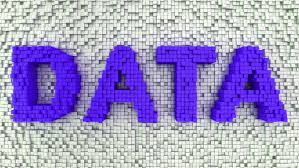

Cargamos los datos aclarando que la variable 'Monto_total 2018' se lea como texto porque sino le lee mal.

In [21]:
data = pd.read_csv("/home/fvadell/ml-tests/labs-ml-group/churn/Brasil deep dive - Plana.csv", dtype={'Monto_total 2018': object})

In [22]:
data.shape

(14083, 49)

In [23]:
data.head()

,pais,ano_alta,idclientecrm,tipo_cliente,CLIENTE GRUPO,Status Cliente,Monto_total 2018,ARPA (rev prom),Lead Venta Formulario,Lead Venta Ver Dato,...,Stock,Integrador,Antigüedad,AO Venta,AO Alquiler,AO Alquiler temporal,% Uso,User vendedor,Equipo,Provincia
0,Brasil,2018,10400002,small,Small,Vigente,8.441,703.000,187,111,...,NaN,NO,2016-11-05,#ERROR!,#ERROR!,#ERROR!,NaN,#ERROR!,#ERROR!,#ERROR!
1,Brasil,2018,10400005,small,Small,Vigente,3.982,332.000,20,18,...,NaN,SI,2016-11-05,3,25,0,56%,rodrigo.serpa,Distrito Federal - Farmers,Distrito Federal
2,Brasil,2018,10400007,small,Small,Vigente,2.871,239.000,93,110,...,NaN,NO,2016-11-05,16,30,0,100%,jaqueline.lopes@wimoveis.com,Distrito Federal - Farmers,Distrito Federal
3,Brasil,2018,10400010,Big,Big,Cancelado,13.530,1.353,184,123,...,NaN,SI,2016-11-05,165,110,0,3%,juliana@wimoveis.com,Distrito Federal - Farmers,Distrito Federal
4,Brasil,2018,10400013,small,Small,Vigente,1.790,179.000,1,-,...,NaN,NO,2016-11-05,2,3,0,83%,patricia@wimoveis.com,Distrito Federal - Farmers,Distrito Federal


Sacamos la primer fila que tiene errores

In [24]:
data.drop(0, axis = 0, inplace = True)

Cambiamos las ',' por '.' y removemos los '.'.

In [25]:
for c in list(data.columns):
    try:
        data[c] = data[c].str.replace('.', '')
        data[c] = data[c].str.replace(',', '.')
    except:
        print(c)

ano_alta
idclientecrm
ARPA (rev prom)
LEADS
Mix D
Stock


### Variables explicativas

Iniciamos las variables explicativas como todas las columnas del dataset e iremos sacando las que no sirven

In [26]:
data.columns

Index(['pais', 'ano_alta', 'idclientecrm', 'tipo_cliente', 'CLIENTE GRUPO',
       'Status Cliente', 'Monto_total 2018', 'ARPA (rev prom)',
       'Lead Venta Formulario', 'Lead Venta Ver Dato',
       'Lead Alquiler Formulario', 'Lead Alquiler Ver Dato',
       'Lead Alquiler temporal Formulario', 'Lead Alquiler temporal Ver Dato',
       'CP Lead Venta Formulario', 'CP Lead Venta Ver Dato',
       'CP Lead Alquiler Formulario', 'CP Lead Alquiler Ver Dato',
       'CP Lead Alquiler temporal Formulario',
       'CP Lead Alquiler temporal Ver Dato', 'LEADS',
       'contratado Super Destacado', 'contratado Destacado',
       'contratado Simple', 'contratado Desarrollo Super Destacado',
       'contratado Desarrollo Destacado', 'contratado Desarrollo Simple',
       'contratado freemium', 'Fecha Alta', 'Fecha Vto',
       'Cliente Ilimitado sin Destaque', 'Cliente Limitado', 'SD', 'D', 'S',
       'Mix SD', 'Mix D', 'Mix S', 'Mix Premium', 'Stock', 'Integrador',
       'Antigüedad', 'AO 

In [27]:
variables = list(data.columns)

Le saco la variable __Status Cliente__ porque es el target.

In [28]:
variables.remove('Status Cliente')

Saco las variables pais, ano_alta, idclientecrm, User vendedor

In [29]:
for var in ['pais', 'ano_alta', 'idclientecrm', 'User vendedor'] : variables.remove(var)

#### Caso de la columna tipo_cliente y CLIENTE GRUPO

Estas dos columnas parecen tener la misma información. Lo revisos:

In [30]:
data['tipo_cliente'].unique(), data['CLIENTE GRUPO'].unique()

(array(['small', 'Big'], dtype=object),
 array(['Small', 'Big', 'Desarrollo'], dtype=object))

In [31]:
data['tipo_cliente'] = ['Small' if x=='small' else x for x in data['tipo_cliente']]

Cantidad de coincidencias entre la columna tipo_cliente y CLIENTE GRUPO

In [32]:
np.where(data['tipo_cliente'] == data['CLIENTE GRUPO'], True, False).sum()

13543

Porcentaje de coincidencias

In [33]:
np.where(data['tipo_cliente'] == data['CLIENTE GRUPO'], True, False).sum()*100/len(data)

96.17241869052691

Por lo tanto, no usaremos la columna __tipo_cliente__ porque tiene prácticamente la misma información que __CLIENTE GRUPO__

In [34]:
variables.remove('tipo_cliente')

Por último vamos a cambiar el valor de 'Small' por 0 y 'Big' por 1

In [35]:
data['CLIENTE GRUPO'] = ['0' if x == 'Small' else '1' for x in data['CLIENTE GRUPO']]

#### Caso columna Stock

Parece no tener datos: Nos fijamos:

In [36]:
len(data[data['Stock'].notna()])

0

La columna __Stock__ no tiene datos así que (por ahora) la dropeo

In [37]:
variables.remove('Stock')

#### Caso columnas Mix

Las columnas mix son complejas y sólo se aplican si la columna _Ilimtado Sin Destaque_ es 0. Por ahora las sacamos:

In [38]:
for var in ['Mix SD', 'Mix D', 'Mix S', 'Mix Premium'] : variables.remove(var)

#### Caso columna % Uso

Tiene un %98 de datos no nulos, pero no sabemos muy bien qué lógica encierra así que por ahora lo dejamos afuera de las variables explicativas.

In [39]:
len(data[data['% Uso'].notna()])/len(data)

0.9813236756142594

In [40]:
variables.remove('% Uso')

#### Caso Cliente Ilimitado sin Destaque vs Cliente Limitado

Solo la primer fila tiene error en estas columnas.

Lo que haremos es ver en cuántas veces son distintas. Si siempre son distintas significa que son opuestas.

In [41]:
data[(data['Cliente Limitado']!='1')&(data['Cliente Limitado']!='0')].filter(['Cliente Ilimitado sin Destaque', 'Cliente Limitado'])

,Cliente Ilimitado sin Destaque,Cliente Limitado


In [42]:
data[(data['Cliente Ilimitado sin Destaque']!='1')&(data['Cliente Ilimitado sin Destaque']!='0')].filter(['Cliente Ilimitado sin Destaque', 'Cliente Limitado'])

,Cliente Ilimitado sin Destaque,Cliente Limitado


In [43]:
data['Cliente Ilimitado sin Destaque'].unique(), data['Cliente Limitado'].unique()

(array(['0', '1'], dtype=object), array(['1', '0'], dtype=object))

In [44]:
np.where(data['Cliente Ilimitado sin Destaque'] != data['Cliente Limitado'], True, False).sum()*100/len(data)

100.0

Casi en el 100% de los datos estas columnas son opuestas, así que sacaremos _Cliente Ilimtado sin Destaque_.

In [45]:
variables.remove('Cliente Ilimitado sin Destaque')

#### Caso Lead Alquiler Formulario' 'Lead Alquiler Ver Dato' 'Lead Alquiler temporal Formulario' 'Lead Alquiler temporal Ver Dato

Estas columnas tienen un '  -   ' en vez de 0. Vamos a reemplazarlos por 0.

In [46]:
for column in ['Lead Venta Formulario', 'Lead Venta Ver Dato','Lead Alquiler Formulario', 'Lead Alquiler Ver Dato','Lead Alquiler temporal Formulario', 'Lead Alquiler temporal Ver Dato']:
    data[column] = data[column].replace('  -   ' ,'0')
    data[column] = data[column].astype(float)

Además vamos a unir las de Formulario con las Ver Dato

In [47]:
data['Lead Venta'] = data['Lead Venta Formulario'] + data['Lead Venta Ver Dato']
#variables.append('Lead Venta')
data['Lead Alquiler'] = data['Lead Alquiler Formulario'] + data['Lead Alquiler Ver Dato']
#variables.append('Lead Alquiler')
data['Lead Alquiler temporal'] = data['Lead Alquiler temporal Formulario'] + data['Lead Alquiler temporal Ver Dato']
#variables.append('Lead Alquiler temporal')

In [48]:
#for column in ['Lead Venta Formulario', 'Lead Venta Ver Dato','Lead Alquiler Formulario', 'Lead Alquiler Ver Dato','Lead Alquiler temporal Formulario', 'Lead Alquiler temporal Ver Dato']:
#    variables.remove(column)

#### Caso Monto_total 2018

Así como está, la columna monto es de tipo object, es decir que se está interpretando como texto. La volvemos a pasar a tipo float.

In [49]:
data['Monto_total 2018']=data['Monto_total 2018'].astype(float)

#### Caso columna Integrador

Toma valores 'SI' y 'NO' que cambio por '1' y '0' respectivamente

In [50]:
data['Integrador'].unique()

array(['SI', 'NO'], dtype=object)

In [51]:
data['Integrador'] = ['1' if x=='SI' else '0' for x in data['Integrador']]

#### Caso columnas CP

Las columnas CP Lead Venta Formulario', 'CP Lead Venta Ver Dato',
       'CP Lead Alquiler Formulario', 'CP Lead Alquiler Ver Dato',
       'CP Lead Alquiler temporal Formulario',
       'CP Lead Alquiler temporal Ver Dato'
Se forman haciendo el monto total dividido los Leads correspondientes, pero trae problemas cuando no hay leads.

En caso que no haya leads vamos a reemplazar este campo por el Monto_total 2018, es decir hacer como si hubera habido un sólo lead.

Los pasos que vamos a hacer son:

Primero tomamos los campos donde hay valores raros (no numéricos) y los cambiamos por ''
Luego cambiamos los '' por nan
Y llenamoms los nan con los valores de la columna de 'Monto_total 2018'

In [52]:
cps = ['CP Lead Venta Formulario', 'CP Lead Venta Ver Dato',
       'CP Lead Alquiler Formulario', 'CP Lead Alquiler Ver Dato',
       'CP Lead Alquiler temporal Formulario',
       'CP Lead Alquiler temporal Ver Dato']

In [53]:
for col in cps:
    data[col]=data[col].str.replace("[^0-9]",'')
    data = data.replace('', np.nan)
    data[col] = data[col].fillna(data['Monto_total 2018'])
    data[col] = data[col].astype(float)

In [54]:
# Si se quieren sacar de las variables explicativas hay que correr lo siguiente

#for column in ['CP Lead Venta Formulario', 'CP Lead Venta Ver Dato',
#       'CP Lead Alquiler Formulario', 'CP Lead Alquiler Ver Dato',
#       'CP Lead Alquiler temporal Formulario',
#       'CP Lead Alquiler temporal Ver Dato']:
#    variables.remove(column)

Juntamos las CPL Formulario y las Ver Dato y las sacamos de las variables explcativas

In [55]:
#data['']

In [56]:
data['CP Lead Venta'] = data['CP Lead Venta Formulario'] + data['CP Lead Venta Ver Dato']
data['CP Lead Alquiler'] = data['CP Lead Alquiler Formulario'] + data['CP Lead Alquiler Ver Dato']
data['CP Lead Alquiler temporal'] = data['CP Lead Alquiler temporal Formulario'] + data['CP Lead Alquiler temporal Ver Dato']

Para agregar los cambios corremos lo siguiente:

In [57]:
#for col in cps:
#    variables.remove(col)
#
#variables.append('CP Lead Venta')
#variables.append('CP Lead Alquiler')
#variables.append('CP Lead Alquiler temporal')

#### Caso Fechas

Para el modelo base voy a desestimar las fechas, que son:

'Fecha Alta', 'Fecha Vto' y 'Antigüedad'

In [58]:
for f in ['Fecha Alta', 'Fecha Vto', 'Antigüedad'] : variables.remove(f)

In [59]:
variables

['CLIENTE GRUPO',
 'Monto_total 2018',
 'ARPA (rev prom)',
 'Lead Venta Formulario',
 'Lead Venta Ver Dato',
 'Lead Alquiler Formulario',
 'Lead Alquiler Ver Dato',
 'Lead Alquiler temporal Formulario',
 'Lead Alquiler temporal Ver Dato',
 'CP Lead Venta Formulario',
 'CP Lead Venta Ver Dato',
 'CP Lead Alquiler Formulario',
 'CP Lead Alquiler Ver Dato',
 'CP Lead Alquiler temporal Formulario',
 'CP Lead Alquiler temporal Ver Dato',
 'LEADS',
 'contratado Super Destacado',
 'contratado Destacado',
 'contratado Simple',
 'contratado Desarrollo Super Destacado',
 'contratado Desarrollo Destacado',
 'contratado Desarrollo Simple',
 'contratado freemium',
 'Cliente Limitado',
 'SD',
 'D',
 'S',
 'Integrador',
 'AO Venta',
 'AO Alquiler',
 'AO Alquiler temporal',
 'Equipo',
 'Provincia']

#### Caso Columna LEADS

La columna 'LEADS' no tiene datos asi que la sacamos:

In [60]:
data['LEADS'].isna().sum()/len(data)

1.0

In [61]:
variables.remove('LEADS')

#### Caso Equipo

En una primera instancia vamos a sacar la columna 'Equipo' de las variables explicativas porque no sabemos qué refleja.

In [62]:
variables.remove('Equipo')

#### Caso Columnas AO

Llenamos los valores 'nan' con 0 en las columnas 'AO Venta', 'AO Alquiler' y 'AO Alquiler temporal'

In [63]:
data['AO Venta'] = data['AO Venta'].fillna(0)
data['AO Alquiler'] = data['AO Alquiler'].fillna(0)
data['AO Alquiler temporal'] = data['AO Alquiler temporal'].fillna(0)

In [64]:
# Para sacar estas variables hay que correr lo siguiente

# for ao in ['AO Venta', 'AO Alquiler', 'AO Alquiler temporal'] : variables.remove(ao)

#### Caso columnas contratado

Hay algunos 'NaN' en las columnas de contratados. Las cambio por 0.

In [65]:
contratados = ['contratado Super Destacado','contratado Destacado',
 'contratado Simple',
 'contratado Desarrollo Super Destacado',
 'contratado Desarrollo Destacado',
 'contratado Desarrollo Simple',
 'contratado freemium']

In [66]:
for c in contratados :
    data[c] = data[c].fillna(0)
    print(c+' con información relevante: ', len(data[(data[c]!='0') & (data[c]!=0)])-1)

contratado Super Destacado con información relevante:  7443
contratado Destacado con información relevante:  11731
contratado Simple con información relevante:  13203
contratado Desarrollo Super Destacado con información relevante:  4
contratado Desarrollo Destacado con información relevante:  567
contratado Desarrollo Simple con información relevante:  -1
contratado freemium con información relevante:  -1


Sacamos las columnas 'contratado Desarrollo Simple' y 'contratado freemium' por no tener datos relevantes

In [67]:
variables.remove('contratado Desarrollo Simple')
variables.remove('contratado freemium')

#### Caso columnas ARPA

ARPA es exactamente Monto / 12, por lo tanto es redundante.

In [68]:
variables.remove('ARPA (rev prom)')

#### Caso columnas SD, S, D

Las tres columnas son simplemente la suma de otras dos así que vamos a sacarlas.

In [69]:
variables.remove('SD')
variables.remove('S')
variables.remove('D')

#### Agrego Columna Status Cliente pero numérica

In [70]:
data['Status Cliente Num'] = [1 if x=='Cancelado' else 0 for x in data['Status Cliente']]

In [71]:
np.array(data['Status Cliente Num']).sum()/len(data)

0.4127964777730436

## Variables

#### Todas las variables

In [72]:
data.columns

Index(['pais', 'ano_alta', 'idclientecrm', 'tipo_cliente', 'CLIENTE GRUPO',
       'Status Cliente', 'Monto_total 2018', 'ARPA (rev prom)',
       'Lead Venta Formulario', 'Lead Venta Ver Dato',
       'Lead Alquiler Formulario', 'Lead Alquiler Ver Dato',
       'Lead Alquiler temporal Formulario', 'Lead Alquiler temporal Ver Dato',
       'CP Lead Venta Formulario', 'CP Lead Venta Ver Dato',
       'CP Lead Alquiler Formulario', 'CP Lead Alquiler Ver Dato',
       'CP Lead Alquiler temporal Formulario',
       'CP Lead Alquiler temporal Ver Dato', 'LEADS',
       'contratado Super Destacado', 'contratado Destacado',
       'contratado Simple', 'contratado Desarrollo Super Destacado',
       'contratado Desarrollo Destacado', 'contratado Desarrollo Simple',
       'contratado freemium', 'Fecha Alta', 'Fecha Vto',
       'Cliente Ilimitado sin Destaque', 'Cliente Limitado', 'SD', 'D', 'S',
       'Mix SD', 'Mix D', 'Mix S', 'Mix Premium', 'Stock', 'Integrador',
       'Antigüedad', 'AO 

#### Variables que no necesitan explicación:

pais, ano_alta, idclentecrm, tipo_cliente, Status Cliente, Monto_total 2018, contratado Super Destacado, contratado Desarrollo Super Destacado, CP Lead Venta Formulario, CP Lead Venta Ver Dato, CP Lead Alquiler Formulario, CP Lead Alquiler Ver Dato, CP Lead Alquiler temporal Formulario, CP Lead Alquiler temporal Ver Dato, contratado Simple, contratado Desarrollo Super Destacado, contratado Desarrollo Destacado, contratado Desarrollo Simple, contratado freemium, SD, D, S, User vendedor, Provincia.

#### Variables que necesitan explicación

__Lead Venta Formulario, Lead Venta Ver Dato, Lead Alquiler Formulario, Lead Alquiler Ver Dato, Lead Alquiler temporal Formulario, Lead Alquiler temporal Ver Dato__: ¿Cuál es la diferencia entre Formulario y Ver Dato?

__LEADS__: Esta variable no tiene datos pero ¿debería ser la suma de los anteriores?

__Fecha Vto__: ¿Qué se vence en esta fecha?

__Cliente ilimitado sin Destaque y Cliente Limitado__: Parecen ser opuestas, ¿qué significa cada una?

__Mix Premium, Mix SD, Mix, D, Mix S__: Todas se calculan sólo si es Cliente Ilimitado sin Destaque y es un cociente pero no se entiende la elección del numerador y el denominador.

__AO Venta, AO Alquiler, AO Alquiler temporal__: ¿Que significan estas columnas?

__% Uso__: ¿Qué representa? Según la fórmula de Excel utiliza algunas columnas AO. También tiene el 'problema' de que podría dar más de %100 si no fuera que tiene una cota forzada.

__Antigüedad y Fecha Alta__: Los datos en estas dos columnas no coinciden, ¿deberían? ¿qué nos dice cada una?

#### Comentarios y Referencias

__CLIENTE GRUPO__: Toma los valores 'Small', 'Big' y 'Desarrollo' pero ¿se clasifica en base a qué?. Es importante saber esto porque si se usan los mismos datos del dataset para hacer esta clasificación va a ser mejor sacar esta variable del modelo.

__ARPA__: Se entiende que es el promedio por mes del monto total del año.

__SD__: Suma de 'contratado Super Destacado' y 'contratado Desarrollo Super Destacado'.

__D__: Suma de 'contratado Destacado' y 'contratado Desarrollo Destacado'.

__S__: Suma de 'contratado Simple y 'contratado Desarrollo Simple'.

__ano_alta__: Entiendo que se refiere al año de donde se extraen los datos y no al año donde se dió de alta el usuario. Esa información asumimos que la tiene el campo 'Fecha alta'.

#### Mix Premium

Se calcula con la siguiente fórmula de excel

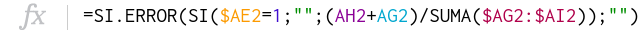

Donde:

__AE__: Cliente Ilimitado sin Destaque (Toma valores 0 y 1)

__AH__: D (Cantidad de Destacados?)

__AG__: SD (Cantdad de Super Destacados?)

__AI__: S (Cantidad de Simples?)

junto small y Small en la misma categoría

#### % Uso

Se calcula con la siguiente fórmula de excel

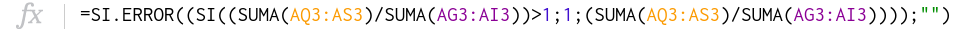

Donde:

__AQ__: AO Venta (Qué es?)

__AS__: AO Alquiler temporal

__AG__: SD (Cantdad de Super Destacados?)

__AI__: S (Cantidad de Simples?)

#### Qué es 'Equipo'?

In [73]:
variables

['CLIENTE GRUPO',
 'Monto_total 2018',
 'Lead Venta Formulario',
 'Lead Venta Ver Dato',
 'Lead Alquiler Formulario',
 'Lead Alquiler Ver Dato',
 'Lead Alquiler temporal Formulario',
 'Lead Alquiler temporal Ver Dato',
 'CP Lead Venta Formulario',
 'CP Lead Venta Ver Dato',
 'CP Lead Alquiler Formulario',
 'CP Lead Alquiler Ver Dato',
 'CP Lead Alquiler temporal Formulario',
 'CP Lead Alquiler temporal Ver Dato',
 'contratado Super Destacado',
 'contratado Destacado',
 'contratado Simple',
 'contratado Desarrollo Super Destacado',
 'contratado Desarrollo Destacado',
 'Cliente Limitado',
 'Integrador',
 'AO Venta',
 'AO Alquiler',
 'AO Alquiler temporal',
 'Provincia']

In [74]:
for var in variables:
    try:
        data[var] = data[var].astype(float)
        data[var] = data[var].astype(float)
    except:
        print("Error con ", var)

Error con  Provincia


In [75]:
data.dtypes

pais                                      object
ano_alta                                   int64
idclientecrm                               int64
tipo_cliente                              object
CLIENTE GRUPO                            float64
Status Cliente                            object
Monto_total 2018                         float64
ARPA (rev prom)                          float64
Lead Venta Formulario                    float64
Lead Venta Ver Dato                      float64
Lead Alquiler Formulario                 float64
Lead Alquiler Ver Dato                   float64
Lead Alquiler temporal Formulario        float64
Lead Alquiler temporal Ver Dato          float64
CP Lead Venta Formulario                 float64
CP Lead Venta Ver Dato                   float64
CP Lead Alquiler Formulario              float64
CP Lead Alquiler Ver Dato                float64
CP Lead Alquiler temporal Formulario     float64
CP Lead Alquiler temporal Ver Dato       float64
LEADS               

### Train y test set

In [240]:
variables

['CLIENTE GRUPO',
 'Monto_total 2018',
 'Lead Venta Formulario',
 'Lead Venta Ver Dato',
 'Lead Alquiler Formulario',
 'Lead Alquiler Ver Dato',
 'Lead Alquiler temporal Formulario',
 'Lead Alquiler temporal Ver Dato',
 'CP Lead Venta Formulario',
 'CP Lead Venta Ver Dato',
 'CP Lead Alquiler Formulario',
 'CP Lead Alquiler Ver Dato',
 'CP Lead Alquiler temporal Formulario',
 'CP Lead Alquiler temporal Ver Dato',
 'contratado Super Destacado',
 'contratado Destacado',
 'contratado Simple',
 'contratado Desarrollo Super Destacado',
 'contratado Desarrollo Destacado',
 'Cliente Limitado',
 'Integrador',
 'AO Venta',
 'AO Alquiler',
 'AO Alquiler temporal',
 'Provincia']

In [241]:
dummies = pd.get_dummies(data.filter(['Provincia']))
dummies.columns

Index(['Provincia_Alagoas', 'Provincia_Amazonas', 'Provincia_Bahia',
       'Provincia_Ceará', 'Provincia_Distrito Federal',
       'Provincia_Espírito Santo', 'Provincia_Goiás', 'Provincia_Maranhão',
       'Provincia_Mato Grosso', 'Provincia_Mato Grosso Do Sul',
       'Provincia_Minas Gerais', 'Provincia_Paraná', 'Provincia_Paraíba',
       'Provincia_Pará', 'Provincia_Pernambuco', 'Provincia_Piauí',
       'Provincia_Rio De Janeiro', 'Provincia_Rio Grande Do Norte',
       'Provincia_Rio Grande Do Sul', 'Provincia_Rondônia',
       'Provincia_Roraima', 'Provincia_Santa Catarina', 'Provincia_Sergipe',
       'Provincia_São Paulo', 'Provincia_Tocantins'],
      dtype='object')

In [242]:
#dummies.drop('Provincia_#ERROR!', axis=1, inplace=True)

In [243]:
data_dummies = data.join(dummies).reset_index(drop = True)

In [244]:
variables = variables + list(dummies.columns)
variables.remove('Provincia')

In [245]:
data_dummies.drop(0, inplace = True)

In [246]:
data_dummies = data_dummies.reset_index(drop = True)

In [247]:
data_dummies = data_dummies.filter(['idclientecrm'] + variables + ['Status Cliente'])

In [248]:
X = data_dummies.filter(['idclientecrm'] + variables)
y = data_dummies.filter(['idclientecrm', 'Status Cliente'])

Aca creo el train y validation set usando la función random.choice que me permite tomar una muestra aleatoria de índices sin reposición. Le seteo el seed en 1 para poder después guardar los modelos

In [249]:
np.random.seed(2)
test_pct = 0.15
test_idx = np.random.choice(range(0, len(X)), round(test_pct*len(X)), replace=False)

In [250]:
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

In [251]:
X_train = X.drop(test_idx, axis = 0)
y_train = y.drop(test_idx, axis = 0)

Chequeo que la cantidad de Clientes Small y Clientes Big tienen mas o menos la misma proporción en ambos conjuntos

In [252]:
np.array(X_test['CLIENTE GRUPO'].astype(int)).sum()/len(X_test), np.array(X_train['CLIENTE GRUPO'].astype(int)).sum()/len(X_train)

(0.08191287878787878, 0.09424346227755034)

Seteo todas las columnas como float

In [253]:
for var in variables:
    print(var)
    X_train[var] = X_train[var].astype(float)
    X_test[var] = X_test[var].astype(float)

CLIENTE GRUPO
Monto_total 2018
Lead Venta Formulario
Lead Venta Ver Dato


/home/fvadell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Lead Alquiler Formulario
Lead Alquiler Ver Dato
Lead Alquiler temporal Formulario
Lead Alquiler temporal Ver Dato
CP Lead Venta Formulario
CP Lead Venta Ver Dato
CP Lead Alquiler Formulario
CP Lead Alquiler Ver Dato
CP Lead Alquiler temporal Formulario
CP Lead Alquiler temporal Ver Dato
contratado Super Destacado
contratado Destacado
contratado Simple
contratado Desarrollo Super Destacado
contratado Desarrollo Destacado
Cliente Limitado
Integrador
AO Venta
AO Alquiler
AO Alquiler temporal
Provincia_Alagoas
Provincia_Amazonas
Provincia_Bahia
Provincia_Ceará
Provincia_Distrito Federal
Provincia_Espírito Santo
Provincia_Goiás
Provincia_Maranhão
Provincia_Mato Grosso
Provincia_Mato Grosso Do Sul
Provincia_Minas Gerais
Provincia_Paraná
Provincia_Paraíba
Provincia_Pará
Provincia_Pernambuco
Provincia_Piauí
Provincia_Rio De Janeiro
Provincia_Rio Grande Do Norte
Provincia_Rio Grande Do Sul
Provincia_Rondônia
Provincia_Roraima
Provincia_Santa Catarina
Provincia_Sergipe
Provincia_São Paulo
Provin

### Correlación

In [254]:
provincias = ['Provincia_Alagoas',
 'Provincia_Amazonas',
 'Provincia_Bahia',
 'Provincia_Ceará',
 'Provincia_Distrito Federal',
 'Provincia_Espírito Santo',
 'Provincia_Goiás',
 'Provincia_Maranhão',
 'Provincia_Mato Grosso',
 'Provincia_Mato Grosso Do Sul',
 'Provincia_Minas Gerais',
 'Provincia_Paraná',
 'Provincia_Paraíba',
 'Provincia_Pará',
 'Provincia_Pernambuco',
 'Provincia_Piauí',
 'Provincia_Rio De Janeiro',
 'Provincia_Rio Grande Do Norte',
 'Provincia_Rio Grande Do Sul',
 'Provincia_Rondônia',
 'Provincia_Roraima',
 'Provincia_Santa Catarina',
 'Provincia_Sergipe',
 'Provincia_São Paulo',
 'Provincia_Tocantins']

In [255]:
X_train.columns

Index(['idclientecrm', 'CLIENTE GRUPO', 'Monto_total 2018',
       'Lead Venta Formulario', 'Lead Venta Ver Dato',
       'Lead Alquiler Formulario', 'Lead Alquiler Ver Dato',
       'Lead Alquiler temporal Formulario', 'Lead Alquiler temporal Ver Dato',
       'CP Lead Venta Formulario', 'CP Lead Venta Ver Dato',
       'CP Lead Alquiler Formulario', 'CP Lead Alquiler Ver Dato',
       'CP Lead Alquiler temporal Formulario',
       'CP Lead Alquiler temporal Ver Dato', 'contratado Super Destacado',
       'contratado Destacado', 'contratado Simple',
       'contratado Desarrollo Super Destacado',
       'contratado Desarrollo Destacado', 'Cliente Limitado', 'Integrador',
       'AO Venta', 'AO Alquiler', 'AO Alquiler temporal', 'Provincia_Alagoas',
       'Provincia_Amazonas', 'Provincia_Bahia', 'Provincia_Ceará',
       'Provincia_Distrito Federal', 'Provincia_Espírito Santo',
       'Provincia_Goiás', 'Provincia_Maranhão', 'Provincia_Mato Grosso',
       'Provincia_Mato Grosso Do Su

In [256]:
corr = pd.merge(X_train, data.filter(['idclientecrm', 'Status Cliente Num']), on = 'idclientecrm').drop(provincias + ['idclientecrm'], axis = 1).corr()

In [257]:
corr.columns

Index(['CLIENTE GRUPO', 'Monto_total 2018', 'Lead Venta Formulario',
       'Lead Venta Ver Dato', 'Lead Alquiler Formulario',
       'Lead Alquiler Ver Dato', 'Lead Alquiler temporal Formulario',
       'Lead Alquiler temporal Ver Dato', 'CP Lead Venta Formulario',
       'CP Lead Venta Ver Dato', 'CP Lead Alquiler Formulario',
       'CP Lead Alquiler Ver Dato', 'CP Lead Alquiler temporal Formulario',
       'CP Lead Alquiler temporal Ver Dato', 'contratado Super Destacado',
       'contratado Destacado', 'contratado Simple',
       'contratado Desarrollo Super Destacado',
       'contratado Desarrollo Destacado', 'Cliente Limitado', 'Integrador',
       'AO Venta', 'AO Alquiler', 'AO Alquiler temporal',
       'Status Cliente Num'],
      dtype='object')

In [258]:
corr['total'] = corr.iloc[:, :-1].sum(axis=1)

Reordenamos las filas

In [259]:
corr = corr.sort_values(by='total', ascending = False)

Reordenamos las columnas

In [260]:
corr = corr.filter(list(corr.index))

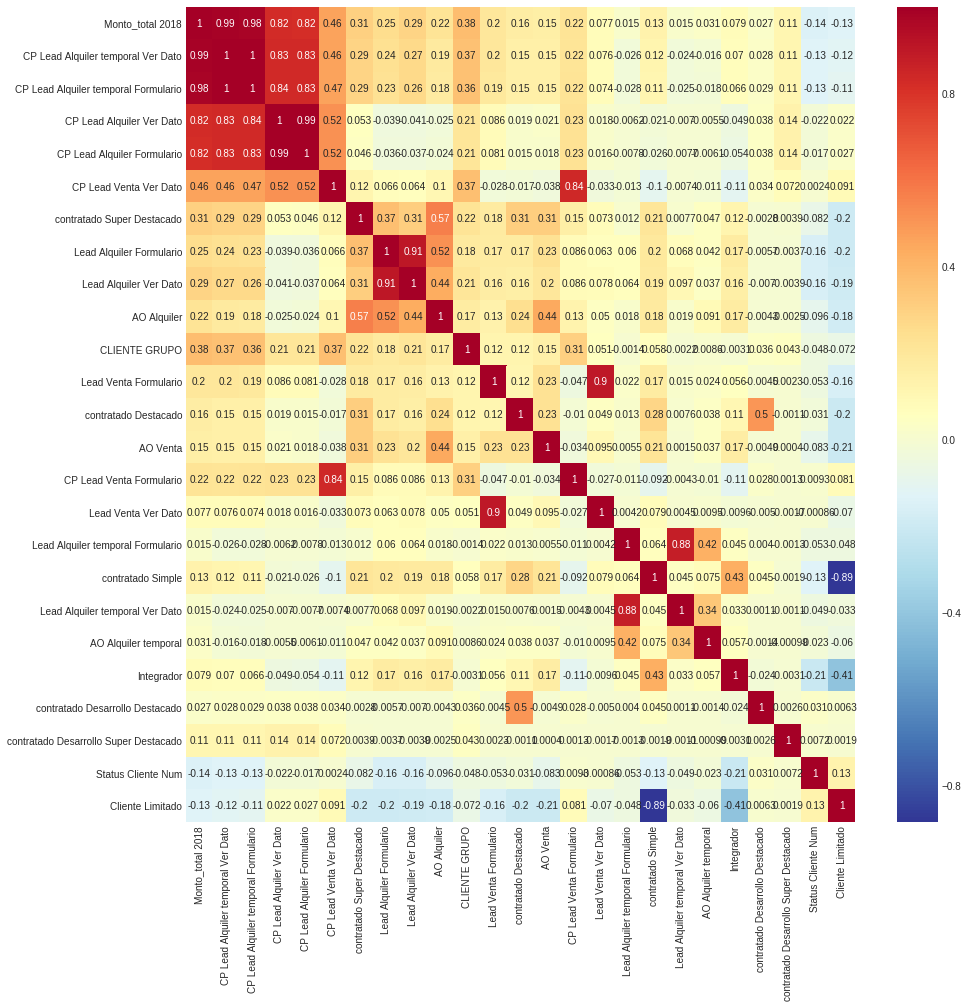

In [261]:
plt.figure(figsize = (15,15))
sns.heatmap(corr, annot=True, cmap="RdYlBu_r")
plt.show();

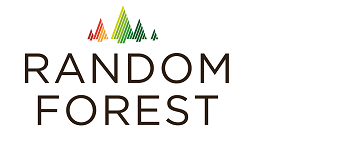

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, criterion = 'gini')
rfc.fit(X_train.drop('idclientecrm', axis = 1), y_train.drop('idclientecrm', axis = 1)) #si le saco el ravel() me tira un warning
y_pred = rfc.predict(X_test.drop('idclientecrm', axis = 1))
y_pred_proba = rfc.predict_proba(X_test.drop('idclientecrm', axis = 1))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_pred, y_test['Status Cliente'])

In [ ]:
plot_confussion_matrix(confusion, strategy = 'Random Forest')
print_metrics(confusion, len(y_test))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 50, 80, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, n_jobs = 2)
rf_random.fit(X_train.drop('idclientecrm', axis = 1), y_train.drop('idclientecrm', axis = 1))

In [ ]:
rf_random.best_params_

In [ ]:
def fit_n_estimators(X_train, y_train, X_test, y_test, value, iterations = 5, scope = 1):
    n = iterations
    n_est = []
    metric = []
    for i in range(-n+1, n):
        trees = round(value*(1-scope*i/n))
        if trees > 0:
            n_est.append(round(value*(1-scope*i/n)))
            rfc = RandomForestClassifier(n_estimators=value,
                                  criterion = 'gini', 
                                  min_samples_split = 2, 
                                  min_samples_leaf = 2,
                                  max_features = 'auto',
                                  max_depth = 50,
                                  bootstrap = True,
                                  )
            rfc.fit(X_train, y_train.ravel())
            metric.append(rfc.score(X_test, y_test))
    return n_est, metric

In [ ]:
rf_res = pd.DataFrame()
rf_res['trees'], rf_res['accuracy'] = fit_n_estimators(X_train.drop('idclientecrm',axis = 1).values, y_train.drop('idclientecrm',axis = 1).values, X_test.drop('idclientecrm',axis = 1).values, y_test.drop('idclientecrm',axis = 1).values, value = 700, iterations = 40, scope = 2.5)

In [ ]:
ax = plt.plot(rf_res['trees'], smooth_curve(rf_res['accuracy']))
ax1 = plt.plot(rf_res['trees'], smooth_curve(rf_res['accuracy'], window = 1), color = 'red', alpha = .3)
plt.grid()
plt.show()

In [ ]:
rfc2 = RandomForestClassifier(n_estimators=1000,
                              criterion = 'gini', 
                              min_samples_split = 2, 
                              min_samples_leaf = 2,
                              max_features = 'auto',
                              max_depth = 50,
                              bootstrap = True)
rfc2.fit(X_train.drop('idclientecrm', axis = 1), y_train.drop('idclientecrm', axis = 1)) #si le saco el ravel() me tira un warning
y_pred2 = rfc2.predict(X_test.drop('idclientecrm', axis = 1))
y_pred_proba2 = rfc2.predict_proba(X_test.drop('idclientecrm', axis = 1))

In [ ]:
confusion = confusion_matrix(y_pred2, y_test['Status Cliente'])

In [ ]:
plot_confussion_matrix(confusion, strategy = 'Random Forest')
print_metrics(confusion, len(y_test))

In [ ]:
X_test.head()

In [ ]:
def create_result_df(y_pred, y_test, y_pred_proba, strategy = ''):
    trust = [x.max() for x in y_pred_proba]
    cancelado_proba = y_pred_proba[:, 0]
    preds_df = pd.DataFrame()
    preds_df['idclientecrm'] = list(y_test['idclientecrm'])
    #preds_df['y_test'] = list(y_test.reshape(1, -1)[0])
    #preds_df['y_test'] = list(y_test[:,1].ravel())
    preds_df[strategy+'_pred'] = y_pred
    preds_df[strategy+'_trust'] = trust
    preds_df[strategy+'_Cancelado probability'] = cancelado_proba
    preds_df[strategy+'_Correct'] = np.where(list(y_test['Status Cliente']) == preds_df[strategy+'_pred'], True, False)
    return pd.merge(y_test, preds_df, on = 'idclientecrm')

In [ ]:
rf2_result_df = create_result_df(y_pred2, y_test, y_pred_proba, strategy = 'rf')

In [ ]:
rf2_result_df.sort_values('rf_trust').tail(10)

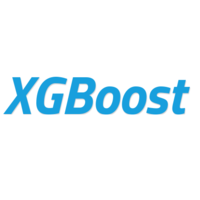

In [262]:
import xgboost as xgb
from xgboost import XGBClassifier

/home/fvadell/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/fvadell/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [263]:
def create_result_df(y_pred, y_test, y_pred_proba, strategy = ''):
    trust = [x.max() for x in y_pred_proba]
    cancelado_proba = y_pred_proba[:, 0]
    preds_df = pd.DataFrame()
    preds_df['idclientecrm'] = list(y_test['idclientecrm'])
    #preds_df['y_test'] = list(y_test.reshape(1, -1)[0])
    #preds_df['y_test'] = list(y_test[:,1].ravel())
    preds_df[strategy+'_pred'] = y_pred
    preds_df[strategy+'_trust'] = trust
    preds_df[strategy+'_Cancelado probability'] = cancelado_proba
    preds_df[strategy+'_Correct'] = np.where(list(y_test['Status Cliente']) == preds_df[strategy+'_pred'], True, False)
    return pd.merge(y_test, preds_df, on = 'idclientecrm')

In [264]:
for var in variables:
    X_train[var] = X_train[var].astype(float)
    X_test[var] = X_test[var].astype(float)

/home/fvadell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


''

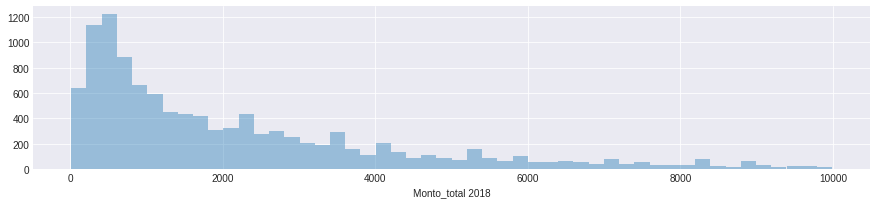

In [265]:
plt.figure(figsize = (15,3))
sns.distplot(X_train[X_train['Monto_total 2018']<10000]['Monto_total 2018'], kde=False, rug=False, bins = 50)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
;

In [266]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=100)
xgb.fit(X_train.drop('idclientecrm', axis = 1), y_train.drop('idclientecrm', axis = 1))
xgb_y_pred=xgb.predict(X_test.drop('idclientecrm', axis = 1))

/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [267]:
xgb_y_pred_proba = xgb.predict_proba(X_test.drop('idclientecrm', axis = 1))

In [268]:
def create_result_df(y_pred, y_test, y_pred_proba, strategy = ''):
    trust = [x.max() for x in y_pred_proba]
    cancelado_proba = y_pred_proba[:, 0]
    preds_df = pd.DataFrame()
    preds_df['idclientecrm'] = list(y_test['idclientecrm'])
    #preds_df['y_test'] = list(y_test.reshape(1, -1)[0])
    #preds_df['y_test'] = list(y_test[:,1].ravel())
    preds_df[strategy+'_pred'] = y_pred
    preds_df['trust'] = trust
    preds_df['Cancelado probability'] = cancelado_proba
    preds_df['Correct'] = np.where(list(y_test['Status Cliente']) == preds_df[strategy+'_pred'], True, False)
    return pd.merge(y_test, preds_df, on = 'idclientecrm')

In [269]:
xgb_result_df = create_result_df(xgb_y_pred, y_test, xgb_y_pred_proba)

In [270]:
xgb_result_df.head(2)

,idclientecrm,Status Cliente,_pred,trust,Cancelado probability,Correct
0,10586058,Vigente,Cancelado,0.632958,0.632958,False
1,47247256,Vigente,Cancelado,0.802098,0.802098,False


In [271]:
confusion = confusion_matrix(xgb_result_df['_pred'], y_test['Status Cliente'])

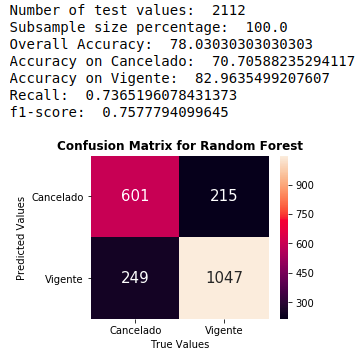

Number of test values:  2112
Subsample size percentage:  100.0
Overall Accuracy:  77.98295454545455
Accuracy on Cancelado:  72.04058624577226
Accuracy on Vigente:  82.28571428571428
Recall:  0.7464953271028038
f1-score:  0.7627984344422699


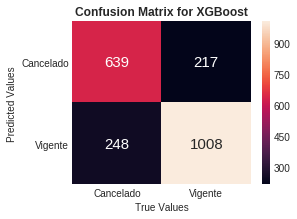

In [272]:
plot_confussion_matrix(confusion, strategy = 'XGBoost')
print_metrics(confusion, len(y_test))

#### Refinamientos de hiperparámetros

In [ ]:
xgb.get_params

In [ ]:
n_estimators = [100]
learning_rate = [0.1]
min_child_weight = [1,2,5]
gamma = [0, 0.5, 1]
max_depth = [3, 5, 6]
colsample_bytree = [0.5, 0.75, 1]


random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'gamma': gamma,
               'min_child_weight': min_child_weight,
               'colsample_bytree': colsample_bytree}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
xgb_random.fit(X_train[variables_old], y_train.drop('idclientecrm', axis = 1))

In [ ]:
# Actual
xgb_random.best_params_

In [ ]:
xgb_random.best_params_

In [ ]:
def xgb_fit_n_estimators(X_train, y_train, X_test, y_test, value = 100, iterations = 40, scope = 1.5):
    n = iterations
    n_est = []
    metric = []
    for i in range(-n+1, n):
        estimator = round(value*(1-scope*i/n))
        if estimator > 0:
            n_est.append(estimator)
            _ = XGBClassifier(learning_rate=0.1,
                    n_estimators=estimator,
                    min_child_weight=2,
                    max_depth= 6,
                    gamma = 0.5,
                    colsample_bytree = 0.5)
            _.fit(X_train, y_train)
            metric.append(_.score(X_test, y_test))
    return n_est, metric

In [ ]:
X_train[variables_old]

In [ ]:
xgb_res = pd.DataFrame()
xgb_res['estimators'], xgb_res['accuracy'] = xgb_fit_n_estimators(X_train[variables_old], y_train.drop('idclientecrm', axis = 1), X_test[variables_old], y_test.drop('idclientecrm', axis = 1), value = 500, iterations = 40, scope = 1)
plt.figure(figsize = (10,3))
ax = plt.plot(xgb_res['estimators'], smooth_curve(xgb_res['accuracy']))
ax1 = plt.plot(xgb_res['estimators'], smooth_curve(xgb_res['accuracy'], window = 1), color = 'red', alpha = .3)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [ ]:
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=400,
                    min_child_weight=2,
                    max_depth= 6,
                    gamma = 0.5,
                    colsample_bytree = 0.5)
xgb2.fit(X_train.drop(['idclientecrm'], axis = 1),y_train.drop('idclientecrm', axis = 1))
xgb2_y_pred=xgb2.predict(X_test.drop(['idclientecrm'], axis = 1))
xgb2_y_pred_proba = xgb2.predict_proba(X_test.drop(['idclientecrm'], axis = 1))

In [ ]:
xgb_result_df = create_result_df(xgb2_y_pred,y_test, xgb2_y_pred_proba, strategy='xgb')

In [ ]:
xgb_result_df.head(2)

In [ ]:
confusion = confusion_matrix(xgb_result_df['xgb_pred'], xgb_result_df['Status Cliente'])

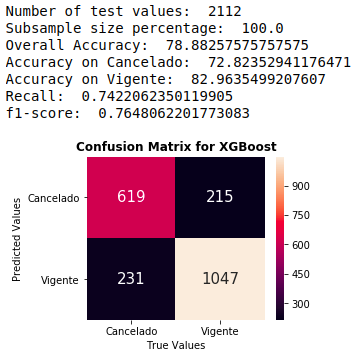

Antes de unir los Leads
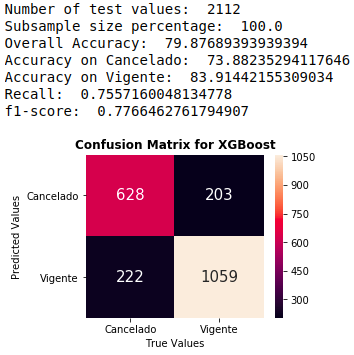

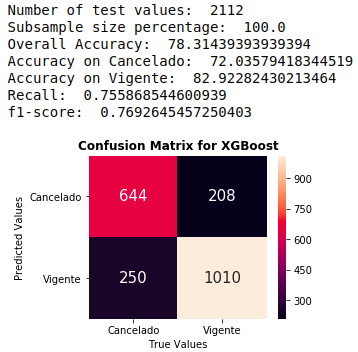

In [ ]:
plot_confussion_matrix(confusion, strategy = 'XGBoost')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top_preds = xgb_result_df[xgb_result_df['xgb_trust']>0.75]
confusion = confusion_matrix(xgb2_top_preds['xgb_pred'], xgb2_top_preds['Status Cliente'])
plot_confussion_matrix(confusion, strategy = 'XGBoost')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top_preds = xgb_result_df[xgb_result_df['xgb_trust']>0.9]

In [ ]:
confusion = confusion_matrix(xgb2_top_preds['xgb_pred'], xgb2_top_preds['Status Cliente'])

In [ ]:
plot_confussion_matrix(confusion, strategy = 'XGBoost')
print_metrics(confusion, len(y_test))

In [ ]:
xgb_result_df = pd.merge(xgb_result_df, data.filter(['idclientecrm', 'CLIENTE GRUPO']), on = 'idclientecrm')

In [ ]:
xgb_result_df.head()

In [ ]:
xgb_result_df_big = xgb_result_df[xgb_result_df['CLIENTE GRUPO'] == '1']
xgb_result_df_small = xgb_result_df[xgb_result_df['CLIENTE GRUPO'] != '1']

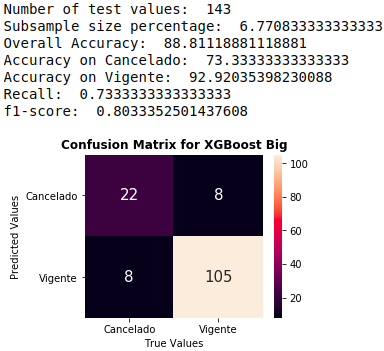

In [ ]:
xgb2_top_preds = xgb_result_df_big[xgb_result_df_big['trust']>0.75]
confusion = confusion_matrix(xgb2_top_preds['xgb_pred'], xgb2_top_preds['Status Cliente'])
plot_confussion_matrix(confusion, strategy = 'XGBoost Big')
print_metrics(confusion, len(y_test))

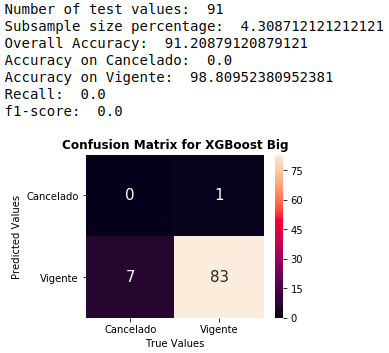

In [ ]:
xgb2_top_preds = xgb_result_df_big[xgb_result_df_big['trust']>0.9]
confusion = confusion_matrix(xgb2_top_preds['xgb_pred'], xgb2_top_preds['Status Cliente'])
plot_confussion_matrix(confusion, strategy = 'XGBoost Big')
print_metrics(confusion, len(y_test))

#### Comparación agregando y sacando variables

In [274]:
removes = ['CP Lead Venta Formulario',
 'CP Lead Venta Ver Dato',
 'CP Lead Alquiler Formulario',
 'CP Lead Alquiler Ver Dato',
 'CP Lead Alquiler temporal Formulario',
 'CP Lead Alquiler temporal Ver Dato','AO Venta',
 'AO Alquiler',
 'AO Alquiler temporal']

In [275]:
variables_basic = variables.copy()
for i in removes:
    variables_basic.remove(i)

In [276]:
variables_old

NameError: name 'variables_old' is not defined

In [277]:
variables_noloc = variables.copy()
for i in provincias:
    variables_noloc.remove(i)

In [278]:
variables_old = variables.copy()

In [279]:
for i in ['AO Venta','AO Alquiler','AO Alquiler temporal','CP Lead Venta Formulario','CP Lead Venta Ver Dato','CP Lead Alquiler Formulario','CP Lead Alquiler Ver Dato','CP Lead Alquiler temporal Formulario','CP Lead Alquiler temporal Ver Dato','contratado Super Destacado']:
    variables_old.remove(i)

In [292]:
variables

['CLIENTE GRUPO',
 'Monto_total 2018',
 'Lead Venta Formulario',
 'Lead Venta Ver Dato',
 'Lead Alquiler Formulario',
 'Lead Alquiler Ver Dato',
 'Lead Alquiler temporal Formulario',
 'Lead Alquiler temporal Ver Dato',
 'CP Lead Venta Formulario',
 'CP Lead Venta Ver Dato',
 'CP Lead Alquiler Formulario',
 'CP Lead Alquiler Ver Dato',
 'CP Lead Alquiler temporal Formulario',
 'CP Lead Alquiler temporal Ver Dato',
 'contratado Super Destacado',
 'contratado Destacado',
 'contratado Simple',
 'contratado Desarrollo Super Destacado',
 'contratado Desarrollo Destacado',
 'Cliente Limitado',
 'Integrador',
 'AO Venta',
 'AO Alquiler',
 'AO Alquiler temporal',
 'Provincia_Alagoas',
 'Provincia_Amazonas',
 'Provincia_Bahia',
 'Provincia_Ceará',
 'Provincia_Distrito Federal',
 'Provincia_Espírito Santo',
 'Provincia_Goiás',
 'Provincia_Maranhão',
 'Provincia_Mato Grosso',
 'Provincia_Mato Grosso Do Sul',
 'Provincia_Minas Gerais',
 'Provincia_Paraná',
 'Provincia_Paraíba',
 'Provincia_Pará',
 

In [293]:
variables_alt = variables_basic.copy()
variables_alt.append('CP Lead Venta')
variables_alt.append('CP Lead Alquiler')
variables_alt.append('CP Lead Alquiler temporal')
variables_alt.append('Lead Venta')
variables_alt.append('Lead Alquiler')
variables_alt.append('Lead Alquiler temporal')
variables_alt.append('AO Venta')
variables_alt.append('AO Alquiler')
variables_alt.append('AO Alquiler temporal')
variables_alt.remove('Lead Venta Formulario')
variables_alt.remove('Lead Venta Ver Dato')
variables_alt.remove('Lead Alquiler Formulario')
variables_alt.remove('Lead Alquiler Ver Dato')
variables_alt.remove('Lead Alquiler temporal Formulario')
variables_alt.remove('Lead Alquiler temporal Ver Dato')

X_train['CP Lead Venta'] = X_train['CP Lead Venta Formulario'] + X_train['CP Lead Venta Ver Dato']
X_test['CP Lead Venta'] = X_test['CP Lead Venta Formulario'] + X_test['CP Lead Venta Ver Dato']

X_train['CP Lead Alquiler'] = X_train['CP Lead Alquiler Formulario'] + X_train['CP Lead Alquiler Ver Dato']
X_test['CP Lead Alquiler'] = X_test['CP Lead Alquiler Formulario'] + X_test['CP Lead Alquiler Ver Dato']

X_train['CP Lead Alquiler temporal'] = X_train['CP Lead Alquiler temporal Formulario'] + X_train['CP Lead Alquiler temporal Ver Dato']
X_test['CP Lead Alquiler temporal'] = X_test['CP Lead Alquiler temporal Formulario'] + X_test['CP Lead Alquiler temporal Ver Dato']

X_train['Lead Venta'] = X_train['Lead Venta Formulario'] + X_train['Lead Venta Ver Dato']
X_test['Lead Venta'] = X_test['Lead Venta Formulario'] + X_test['Lead Venta Ver Dato']

X_train['Lead Alquiler'] = X_train['Lead Alquiler Formulario'] + X_train['Lead Alquiler Ver Dato']
X_test['Lead Alquiler'] = X_test['Lead Alquiler Formulario'] + X_test['Lead Alquiler Ver Dato']

X_train['Lead Alquiler temporal'] = X_train['Lead Alquiler temporal Formulario'] + X_train['Lead Alquiler temporal Ver Dato']
X_test['Lead Alquiler temporal'] = X_test['Lead Alquiler temporal Formulario'] + X_test['Lead Alquiler temporal Ver Dato']

/home/fvadell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fvadell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fvadell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [294]:
variables_alt

['CLIENTE GRUPO',
 'Monto_total 2018',
 'contratado Super Destacado',
 'contratado Destacado',
 'contratado Simple',
 'contratado Desarrollo Super Destacado',
 'contratado Desarrollo Destacado',
 'Cliente Limitado',
 'Integrador',
 'Provincia_Alagoas',
 'Provincia_Amazonas',
 'Provincia_Bahia',
 'Provincia_Ceará',
 'Provincia_Distrito Federal',
 'Provincia_Espírito Santo',
 'Provincia_Goiás',
 'Provincia_Maranhão',
 'Provincia_Mato Grosso',
 'Provincia_Mato Grosso Do Sul',
 'Provincia_Minas Gerais',
 'Provincia_Paraná',
 'Provincia_Paraíba',
 'Provincia_Pará',
 'Provincia_Pernambuco',
 'Provincia_Piauí',
 'Provincia_Rio De Janeiro',
 'Provincia_Rio Grande Do Norte',
 'Provincia_Rio Grande Do Sul',
 'Provincia_Rondônia',
 'Provincia_Roraima',
 'Provincia_Santa Catarina',
 'Provincia_Sergipe',
 'Provincia_São Paulo',
 'Provincia_Tocantins',
 'CP Lead Venta',
 'CP Lead Alquiler',
 'CP Lead Alquiler temporal',
 'Lead Venta',
 'Lead Alquiler',
 'Lead Alquiler temporal',
 'AO Venta',
 'AO Al

In [298]:
xgb_basic = XGBClassifier(learning_rate=0.1,
                    n_estimators=120,
                    min_child_weight=2,
                    max_depth= 6,
                    gamma = 0.5,
                    colsample_bytree = 0.5)
xgb_basic.fit(X_train[variables_basic],y_train.drop('idclientecrm', axis = 1))
xgb_basic_y_pred=xgb_basic.predict(X_test[variables_basic])
xgb_basic_y_pred_proba = xgb_basic.predict_proba(X_test[variables_basic])

/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [299]:
{'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 1}

{'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 1}

In [300]:
xgb_old = XGBClassifier(learning_rate=0.1,
                    n_estimators=100,
                    min_child_weight=5,
                    max_depth= 6,
                    gamma = 0.5,
                    colsample_bytree = 1)
xgb_old.fit(X_train[variables_old],y_train.drop('idclientecrm', axis = 1))
xgb_old_y_pred=xgb_old.predict(X_test[variables_old])
xgb_old_y_pred_proba = xgb_old.predict_proba(X_test[variables_old])

/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [295]:
xgb_alt = XGBClassifier(learning_rate=0.1,
                    n_estimators=120,
                    min_child_weight=2,
                    max_depth= 6,
                    gamma = 0.5,
                    colsample_bytree = 0.5)
xgb_alt.fit(X_train[variables_alt],y_train.drop('idclientecrm', axis = 1))
xgb_alt_y_pred=xgb_alt.predict(X_test[variables_alt])
xgb_alt_y_pred_proba = xgb_alt.predict_proba(X_test[variables_alt])

/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Importancia de features

In [296]:
features = pd.DataFrame()
features['feature'] = variables_alt
features['importance'] = xgb_alt.feature_importances_
features = features.sort_values(by = 'importance', ascending = False).reset_index(drop = True)

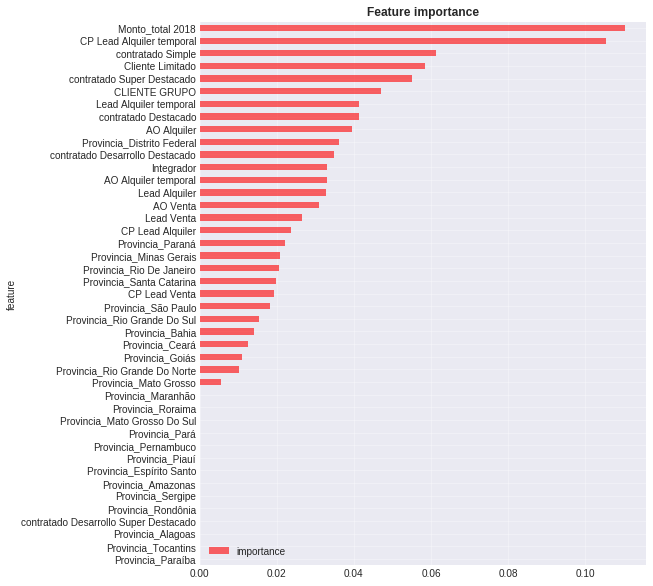

In [297]:
ax = features.sort_values(by = 'importance', ascending = True).plot.barh(x='feature', y='importance', color = 'red', alpha = .6, figsize=(8,10))
plt.title("Feature importance", fontweight = 'bold')
ax.grid(alpha = .4)

In [301]:
xgb_noloc = XGBClassifier(learning_rate=0.1,
                    n_estimators=120,
                    min_child_weight=2,
                    max_depth= 6,
                    gamma = 0.5,
                    colsample_bytree = 0.5)
xgb_noloc.fit(X_train[variables_noloc],y_train.drop('idclientecrm', axis = 1))
xgb_noloc_y_pred=xgb_noloc.predict(X_test[variables_noloc])
xgb_noloc_y_pred_proba = xgb_noloc.predict_proba(X_test[variables_noloc])

/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fvadell/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [302]:
xgb_noloc_result_df = create_result_df(xgb_noloc_y_pred,y_test, xgb_noloc_y_pred_proba, strategy='xgb_noloc')

In [303]:
xgb_basic_result_df = create_result_df(xgb_basic_y_pred,y_test, xgb_basic_y_pred_proba, strategy='xgb_basic')

In [304]:
xgb_alt_result_df = create_result_df(xgb_alt_y_pred,y_test, xgb_alt_y_pred_proba, strategy='xgb_alt')

In [305]:
xgb_old_result_df = create_result_df(xgb_old_y_pred,y_test, xgb_old_y_pred_proba, strategy='xgb_old')

In [307]:
N = len(y_test)

xgb_pc = []
xgb_size = []
xgb_prec = []
xgb_recall = []

xgb_basic_pc = []
xgb_basic_size = []
xgb_basic_prec = []
xgb_basic_recall = []

xgb_alt_pc = []
xgb_alt_size = []
xgb_alt_prec = []
xgb_alt_recall = []

xgb_noloc_pc = []
xgb_noloc_size = []
xgb_noloc_prec = []
xgb_noloc_recall = []

xgb_old_pc = []
xgb_old_size = []
xgb_old_prec = []
xgb_old_recall = []

nn_pc = []
nn_size = []
nn_prec = []
nn_recall = []

iterations = 100
t = [0.9*x/(iterations-1) for x in range(iterations)]
for thresh in t:
    xgboost = xgb_result_df[xgb_result_df['trust']>=thresh]
    xgb_basic = xgb_basic_result_df[xgb_basic_result_df['trust']>=thresh]
    xgb_alt = xgb_alt_result_df[xgb_alt_result_df['trust']>=thresh]
    xgb_noloc = xgb_noloc_result_df[xgb_noloc_result_df['trust']>=thresh]
    xgb_old = xgb_old_result_df[xgb_old_result_df['trust']>=thresh]
    #nn = aux[aux['trust']>=thresh]

    
    confusion = confusion_matrix(xgboost['_pred'], xgboost['Status Cliente'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    xgb_pc.append(p_c)
    subset_per = 100*n/N
    xgb_size.append(subset_per)
    xgb_prec.append(p)
    xgb_recall.append(recall)
    
    confusion = confusion_matrix(xgb_basic['xgb_basic_pred'], xgb_basic['Status Cliente'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    xgb_basic_pc.append(p_c)
    subset_per = 100*n/N
    xgb_basic_size.append(subset_per)
    xgb_basic_prec.append(p)
    xgb_basic_recall.append(recall)
    
    confusion = confusion_matrix(xgb_alt['xgb_alt_pred'], xgb_alt['Status Cliente'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    xgb_alt_pc.append(p_c)
    subset_per = 100*n/N
    xgb_alt_size.append(subset_per)
    xgb_alt_prec.append(p)
    xgb_alt_recall.append(recall)
    
    confusion = confusion_matrix(xgb_noloc['xgb_noloc_pred'], xgb_noloc['Status Cliente'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    xgb_noloc_pc.append(p_c)
    subset_per = 100*n/N
    xgb_noloc_size.append(subset_per)
    xgb_noloc_prec.append(p)
    xgb_noloc_recall.append(recall)
    
    confusion = confusion_matrix(xgb_old['xgb_old_pred'], xgb_old['Status Cliente'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    xgb_old_pc.append(p_c)
    subset_per = 100*n/N
    xgb_old_size.append(subset_per)
    xgb_old_prec.append(p)
    xgb_old_recall.append(recall)
    
    #confusion = confusion_matrix(nn['Veredict'], nn['Status'])
    #n = confusion.sum()
    #p = (confusion[0][0]+confusion[1][1])/n
    #recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    #p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    #nn_pc.append(p_c)
    #subset_per = 100*n/N
    #nn_size.append(subset_per)
    #nn_prec.append(p)
    #nn_recall.append(recall)

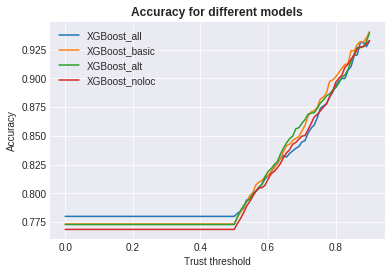

In [308]:
ax1 = plt.plot(t, xgb_prec, label = 'XGBoost_all')
ax2 = plt.plot(t, xgb_basic_prec, label = 'XGBoost_basic')
ax3 = plt.plot(t, xgb_alt_prec, label = 'XGBoost_alt')
ax4 = plt.plot(t, xgb_noloc_prec, label = 'XGBoost_noloc')
#ax5 = plt.plot(t, nn_prec, label = 'NN', color = 'k')

plt.title('Accuracy for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

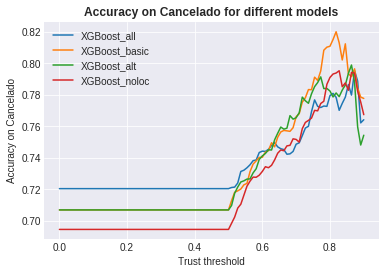

In [309]:
ax1 = plt.plot(t, xgb_pc, label = 'XGBoost_all')
ax2 = plt.plot(t, xgb_basic_pc, label = 'XGBoost_basic')
ax3 = plt.plot(t, xgb_alt_pc, label = 'XGBoost_alt')
ax4 = plt.plot(t, xgb_noloc_pc, label = 'XGBoost_noloc')
#ax5 = plt.plot(t, nn_pc, label = 'NN', color = 'k')


plt.title('Accuracy on Cancelado for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Accuracy on Cancelado')
plt.legend()
plt.show()

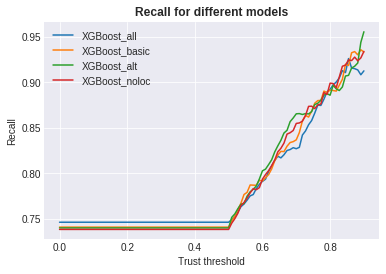

In [310]:
ax1 = plt.plot(t, xgb_recall, label = 'XGBoost_all')
ax2 = plt.plot(t, xgb_basic_recall, label = 'XGBoost_basic')
ax3 = plt.plot(t, xgb_alt_recall, label = 'XGBoost_alt')
ax4 = plt.plot(t, xgb_noloc_recall, label = 'XGBoost_noloc')
#ax5 = plt.plot(t, nn_recall, label = 'NN', color = 'k')


plt.title('Recall for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Recall')
plt.legend()
plt.show()

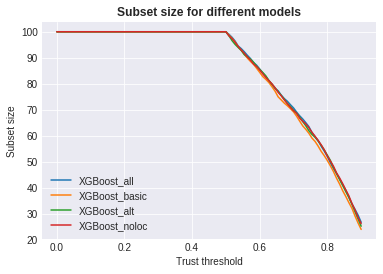

In [311]:
ax1 = plt.plot(t, xgb_size, label = 'XGBoost_all')
ax2 = plt.plot(t, xgb_basic_size, label = 'XGBoost_basic')
ax3 = plt.plot(t, xgb_alt_size, label = 'XGBoost_alt')
ax4 = plt.plot(t, xgb_noloc_size, label = 'XGBoost_noloc')
#ax5 = plt.plot(t, nn_size, label = 'NN', color = 'k')



plt.title('Subset size for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Subset size')
plt.legend()
plt.show()

In [ ]:
xgb_old_top_preds = xgb_old_result_df[xgb_old_result_df['xgb_old_trust']>0.9]
confusion = confusion_matrix(xgb_old_top_preds['xgb_old_pred'], xgb_old_top_preds['Status Cliente'])
plot_confussion_matrix(confusion, strategy = 'XGBoost Big')
print_metrics(confusion, len(y_test))

#### Importancia de features

In [ ]:
features = pd.DataFrame()
features['feature'] = variables
features['importance'] = xgb2.feature_importances_
features = features.sort_values(by = 'importance', ascending = False).reset_index(drop = True)

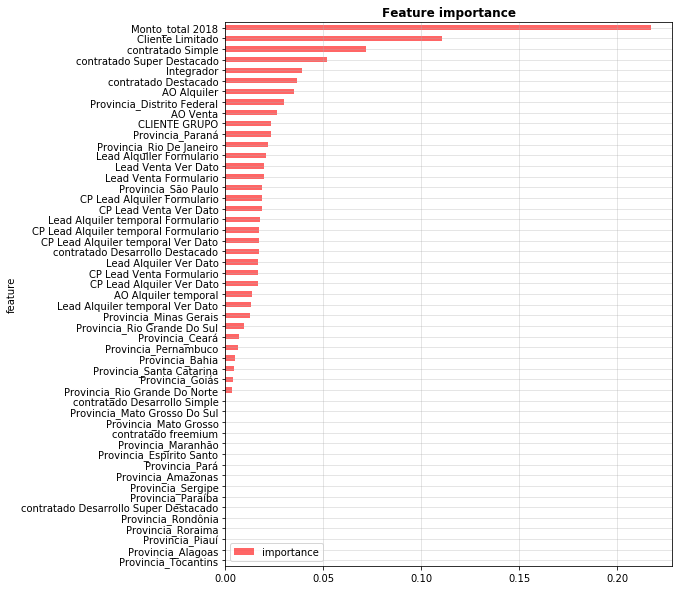

In [205]:
ax = features.sort_values(by = 'importance', ascending = True).plot.barh(x='feature', y='importance', color = 'red', alpha = .6, figsize=(8,10))
plt.title("Feature importance", fontweight = 'bold')
ax.grid(alpha = .4)

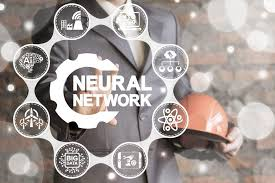

In [904]:
data_dummies['Status Cliente Num'] = [1 if x=='Cancelado' else 0 for x in data_dummies['Status Cliente']]

In [905]:
for i in data_dummies.columns:
    try:
        data_dummies[i].astype(float)
    except:
        print(i)

Status Cliente


In [906]:
df = data_dummies.drop('Status Cliente', axis = 1)
#df = df.sample(frac=1).reset_index(drop=True) #Le aplico un shuffle
for col in variables:
    df[col]=df[col].astype('float')
#df['CLIENTE GRUPO'] = df['CLIENTE GRUPO'].astype('float', inplace = True)
dep_var = 'Status Cliente Num'
cat_names = []
cont_names = variables
y_range = [0, 1]

#procs = [FillMissing, Categorify, Normalize]

In [856]:
df['Status Cliente Num'] = df['Status Cliente Num'].astype(float)

In [907]:
batch_size = 32
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names)
                           .split_by_idx(valid_idx=test_idx)
                           .label_from_df(cols=dep_var)
                           .databunch(bs = batch_size))

In [908]:
learn_tabular = tabular_learner(data, 
                            layers=[1100,800,100,500,300,100],
                            y_range = y_range
                            )

In [909]:
learn_tabular.loss_func

FlattenedLoss of CrossEntropyLoss()

In [910]:
early_stopping = EarlyStoppingFede(learn = learn_tabular, patience = 1)

In [911]:
testCb = TestCallback(learn = learn_tabular)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 8.32E-03


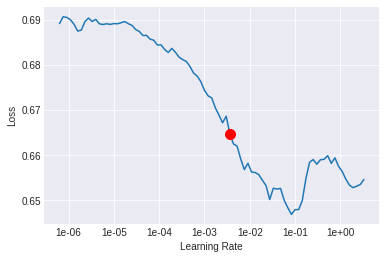

In [912]:
learn_tabular.lr_find()
learn_tabular.recorder.plot(suggestion = True)

In [913]:
learn_tabular.fit_one_cycle(15, max_lr=slice(5.0E-4), callbacks = [testCb], wd = .01)

epoch,train_loss,valid_loss,time
0,0.592984,0.635545,00:23
1,0.573447,0.611586,00:23
2,0.558927,0.564972,00:23
3,0.561784,0.599782,00:24
4,0.562410,0.611923,00:23
5,0.553421,0.574247,00:23
6,0.543225,0.605152,00:24
7,0.544639,0.667224,00:24
8,0.535694,0.682301,00:24
9,0.540452,0.609817,00:26


testCb: Fin de la epoch  1
testCb: Fin de la epoch  2
testCb: Fin de la epoch  3
testCb: Fin de la epoch  4
testCb: Fin de la epoch  5
testCb: Fin de la epoch  6
testCb: Fin de la epoch  7
testCb: Fin de la epoch  8
testCb: Fin de la epoch  9
testCb: Fin de la epoch  10
testCb: Fin de la epoch  11
testCb: Fin de la epoch  12
testCb: Fin de la epoch  13
testCb: Fin de la epoch  14
testCb: Fin de la epoch  15
 
TestCallBack: ¡Gracias por todo! Cantidad de epochs corridas:  15


In [915]:
res = learn_tabular.get_preds(ds_type=DatasetType.Valid)
#res = list(res[0].numpy().ravel())
res = list(np.array(res[0][:,1]))

In [916]:
#trust = [x.max() for x in res[0].numpy()]
trust = [np.array([x,1-x]).max() for x in res]

In [917]:
aux = pd.DataFrame()
aux['Status'] = data_dummies.iloc[test_idx, :]['Status Cliente Num']
aux['pred'] = res
aux['trust'] = trust

In [918]:
aux['Veredict'] = [round(x) for x in aux['pred']]

In [919]:
aux['Correct'] = np.where(aux['Status']== aux['Veredict'], True, False)

In [920]:
print(len(aux[aux['Status']==0])), print(len(aux[aux['Status']==1]))

1225
887


(None, None)

In [921]:
aux.sort_values('trust', ascending = False)

,Status,pred,trust,Veredict,Correct
11154,0,0.731059,0.731059,1,False
9369,1,0.731059,0.731059,1,True
6252,1,0.731059,0.731059,1,True
2512,0,0.731059,0.731059,1,False
7891,0,0.731059,0.731059,1,False
7572,1,0.731059,0.731059,1,True
6870,0,0.731059,0.731059,1,False
7479,0,0.731059,0.731059,1,False
9010,1,0.731059,0.731059,1,True
7575,0,0.731059,0.731059,1,False


In [922]:
confusion = confusion_matrix(aux['Veredict'], aux['Status'])

Number of test values:  2112
Subsample size percentage:  100.0
Overall Accuracy:  69.08143939393939
Accuracy on Cancelado:  92.08163265306123
Accuracy on Vigente:  37.31679819616686
Recall:  0.669833729216152
f1-score:  0.6801623047338329


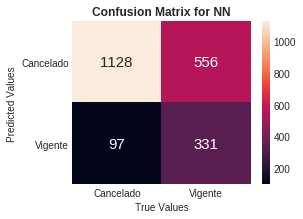

In [923]:
plot_confussion_matrix(confusion=confusion, strategy='NN')
print_metrics(confusion, len(aux))

thresh:  0.5
Number of test values:  2112
Subsample size percentage:  100.0
Overall Accuracy:  69.08143939393939
Accuracy on Cancelado:  92.08163265306123
Accuracy on Vigente:  37.31679819616686
Recall:  0.669833729216152
f1-score:  0.6801623047338329

thresh:  0.6
Number of test values:  1645
Subsample size percentage:  77.88825757575758
Overall Accuracy:  74.77203647416414
Accuracy on Cancelado:  94.28571428571428
Accuracy on Vigente:  36.964285714285715
Recall:  0.7434593023255814
f1-score:  0.7455837455170851

thresh:  0.7
Number of test values:  1223
Subsample size percentage:  57.90719696969697
Overall Accuracy:  81.92968111201962
Accuracy on Cancelado:  96.353591160221
Accuracy on Vigente:  40.88050314465409
Recall:  0.8226415094339623
f1-score:  0.8209657536305962

thresh:  0.8


ValueError: zero-size array to reduction operation minimum which has no identity

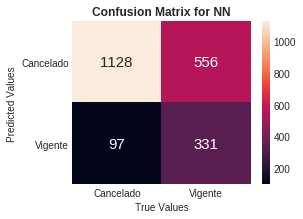

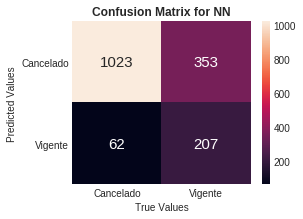

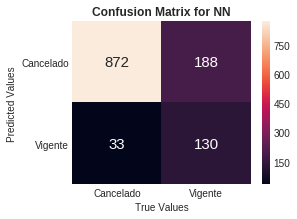

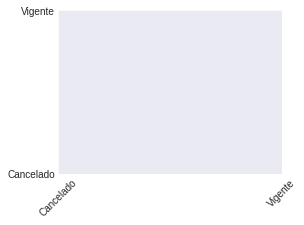

In [924]:
for thresh in [.5,.6,.7,.8,.85,.9]:
    print('thresh: ', thresh)
    df = aux[aux['trust']>=thresh]
    confusion = confusion_matrix(df['Veredict'], df['Status'])
    plot_confussion_matrix(confusion=confusion, strategy='NN')
    print_metrics(confusion, len(aux))
    print("")
    

In [927]:
aux.sort_values('trust', ascending = True)

,Status,pred,trust,Veredict,Correct
8720,0,0.499980,0.500020,0,True
8441,0,0.500340,0.500340,1,False
12765,1,0.500686,0.500686,1,True
7099,1,0.499281,0.500719,0,False
3450,0,0.499122,0.500878,0,True
6005,1,0.499100,0.500900,0,False
3909,1,0.498847,0.501153,0,False
12738,1,0.501566,0.501566,1,True
11489,1,0.498380,0.501620,0,False
13010,1,0.501819,0.501819,1,True


In [429]:
np.array(aux['Correct']).sum()/len(aux)

1.0

In [ ]:
torch.LongTensor(X_test.drop('idclientecrm', axis = 1).values)

In [ ]:
learn_tabular.model??

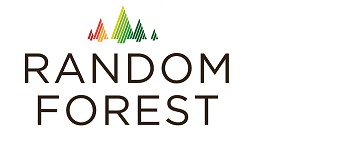

Las variables que usaremos para el modelo base son:

In [ ]:
variables

#### Modelo Base

get_dummies transforma variables categóricas en one-hot encodings

In [ ]:
dummies = pd.get_dummies(data.filter(['Provincia']))
dummies.columns

In [ ]:
dummies.drop('Provincia_#ERROR!', axis=1, inplace=True)

In [ ]:
dummies.head(1)

In [ ]:
data_dummies = data.join(dummies).reset_index(drop = True)

Cambiamos la variable 'Provincia' por one hot encodings de esa misma información

In [ ]:
variables = variables + list(dummies.columns)
variables.remove('Provincia')

Dropeo la primer fila que tiene errores

In [ ]:
data_dummies.drop(0, inplace = True)

In [ ]:
data_dummies = data_dummies.filter(['idclientecrm'] + variables + ['Status Cliente'])

In [ ]:
#data_dummies = data_dummies.filter(variables + ['Status Cliente'])

In [ ]:
X = data_dummies.filter(['idclientecrm'] + variables).values
y = data_dummies.filter(['idclientecrm', 'Status Cliente']).values

In [ ]:
#X = data_dummies.filter(variables).values
#y = data_dummies.filter(['Status Cliente']).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, criterion = 'gini')
rfc.fit(X_train[:,1:], y_train[:,1:].ravel()) #si le saco el ravel() me tira un warning
y_pred = rfc.predict(X_test[:,1:])

In [ ]:
y_pred_proba = rfc.predict_proba(X_test[:,1:])

### Métricas

list(y_test.reshape(1, -1)[0]). Toda esta parafernalia es para poder cambiarle la forma a y_test y podes compararlo contra y_pred

In [ ]:
res = (y_pred == list(y_test[:,1:].reshape(1, -1)[0]))
print('Accuracy: ', res.sum()*100/len(y_test))

In [ ]:
perc_c = np.array([x == 'Cancelado' for x in list(y_test[:,1:].reshape(1, -1)[0])]).sum()*100/len(y_test)

In [ ]:
print('Porcentaje de Cancelados en test set: ', perc_c)

In [ ]:
y_test

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_pred, y_test[:,1:])

In [ ]:
plot_confussion_matrix(confusion=confusion, strategy='Random Forest Classifier')
print_metrics(confusion, len(y_test))

In [ ]:
rf_preds_df = create_result_df(y_pred, y_test, y_pred_proba)

In [ ]:
rf_preds_df.head()

In [ ]:
top_preds = rf_preds_df[rf_preds_df['trust']>0.9]

In [ ]:
confusion = confusion_matrix(top_preds['y_pred'], top_preds['y_test'])

In [ ]:
plot_confussion_matrix(confusion)
print_metrics(confusion, len(y_test))

#### Importancia de variables

Creamos el DataFrame que tiene cada variable acompañada con el 'peso' o importancia que tiene dentro del modelo.

In [ ]:
features = pd.DataFrame()
features['feature'] = variables
features['importance'] = rfc.feature_importances_
features = features.sort_values(by = 'importance', ascending = False).reset_index(drop = True)

In [ ]:
features

#### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross = cross_val_score(rfc, X, y.ravel(), cv = 5)

In [ ]:
cross.mean()

#### Hyper Parametre Tuning 

Vamos a usar SearchGrid de sklearn

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 50, 80, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

El siguiente paso corre el modelo para "casi" todas las combinaciones de hiperparámetros que le dimos. Por esta razon tarda algunos minutos en terminar.

In [ ]:
y_train

In [ ]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(X_train[:,1:], y_train[:,1:].ravel())

Consigo los siguientes parámetros

In [ ]:
rf_random.best_params_

In [ ]:
def fit_n_estimators(X_train, y_train, X_test, y_test, value, iterations = 5, scope = 1):
    n = iterations
    n_est = []
    metric = []
    for i in range(-n+1, n):
        trees = round(value*(1-scope*i/n))
        if trees > 0:
            n_est.append(round(value*(1-scope*i/n)))
            rfc = RandomForestClassifier(n_estimators=value,
                                  criterion = 'gini', 
                                  min_samples_split = 10, 
                                  min_samples_leaf = 4,
                                  max_features = 'sqrt',
                                  max_depth = 20,
                                  bootstrap = True,
                                  )
            rfc.fit(X_train, y_train.ravel())
            metric.append(rfc.score(X_test, y_test))
    return n_est, metric

In [ ]:
rf_res = pd.DataFrame()
rf_res['trees'], rf_res['accuracy'] = fit_n_estimators(X_train[:,1:], y_train[:,1:], X_test[:,1:], y_test[:,1:], value = 500, iterations = 40, scope = 2.5)

In [ ]:
ax = plt.plot(rf_res['trees'], smooth_curve(rf_res['accuracy']))
ax1 = plt.plot(rf_res['trees'], smooth_curve(rf_res['accuracy'], window = 1), color = 'red', alpha = .3)
plt.grid()
plt.show()

Vamos a repetir el entrenamiento con estos parámetros y ver cuánto cambia.

In [ ]:
rfc2 = RandomForestClassifier(n_estimators=1500,
                              criterion = 'gini', 
                              min_samples_split = 10, 
                              min_samples_leaf = 4,
                              max_features = 'sqrt',
                              max_depth = 50,
                              bootstrap = True)
rfc2.fit(X_train[:,1:], y_train[:,1:].ravel()) #si le saco el ravel() me tira un warning
y_pred2 = rfc2.predict(X_test[:,1:])

In [ ]:
y_pred_proba = rfc.predict_proba(X_test[:,1:])

In [ ]:
confusion2 = confusion_matrix(y_pred2, y_test[:,1:])

In [ ]:
plot_confussion_matrix(confusion2)
print_metrics(confusion2, len(y_test))

El modelo mejoró unos puntos respecto al modelo base

In [ ]:
rf2_result_df = create_result_df(y_pred2, y_test, y_pred_proba)

In [ ]:
rf2_result_df.head()

In [ ]:
top_preds = rf2_result_df[rf2_result_df['trust']>.9]

In [ ]:
confusion_top = confusion_matrix(top_preds['y_pred'], top_preds['y_test'])

In [ ]:
plot_confussion_matrix(confusion_top)
print_metrics(confusion_top, len(y_test))

In [ ]:
rf_res = pd.DataFrame()
rf_res['trees'], rf_res['accuracy'] = fit_n_estimators(X_train[:,1:], y_train[:,1:], X_test[:,1:], y_test[:,1:], value = 100, iterations = 40, scope = 1.5)

In [ ]:
ax = plt.plot(rf_res['trees'], smooth_curve(rf_res['accuracy']))
ax1 = plt.plot(rf_res['trees'], smooth_curve(rf_res['accuracy'], window = 1), color = 'red', alpha = .3)
plt.grid()
plt.show()

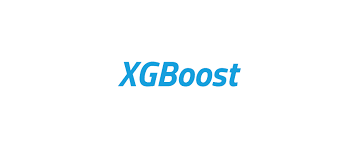

### Modelo base

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

Armamos el modelo base y lo entrenamos

In [ ]:
xgb = XGBClassifier(learning_rate=0.1,n_estimators=100)
xgb.fit(X_train[:,1:],y_train[:,1:].ravel())
xgb_y_pred=xgb.predict(X_test[:,1:])

In [ ]:
xgb_y_pred_proba = xgb.predict_proba(X_test[:,1:])

In [ ]:
xgb_result_df = create_result_df(xgb_y_pred, y_test, xgb_y_pred_proba)

In [ ]:
xgb_result_df.head()

#### Métricas

In [ ]:
xgb_confusion = confusion_matrix(xgb_result_df['y_pred'], xgb_result_df['y_test'])
plot_confussion_matrix(xgb_confusion, strategy = 'XGBoost Classifier')
print_metrics(xgb_confusion, len(y_test))

In [ ]:
xgb_top_preds = xgb_result_df[xgb_result_df['trust']>0.9]

In [ ]:
xgb_confusion_top = confusion_matrix(xgb_top_preds['y_pred'], xgb_top_preds['y_test'])
plot_confussion_matrix(xgb_confusion_top, strategy = 'XGBoost Classifier')
print_metrics(xgb_confusion_top, len(y_test))

In [ ]:
xgb.get_params

#### Refinamiento de hiperparámetros

In [ ]:
n_estimators = [100, 500, 1000]
learning_rate = [0.1, 0.01, 0.001]
min_child_weight = [1, 5, 10]
gamma = [0.5, 1, 1.5, 2, 5]
max_depth = [3, 4, 5]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'gamma': gamma,
               'min_child_weight': min_child_weight}

In [ ]:
xgb_random = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
xgb_random.fit(X_train, y_train)

In [ ]:
xgb_random.best_params_

Buscamos con más precisión el hiperparámetro 'n_estimators'

In [ ]:
xgb_res = pd.DataFrame()
xgb_res['estimators'], xgb_res['accuracy'] = xgb_fit_n_estimators(X_train[:,1:], y_train[:,1:], X_test[:,1:], y_test[:,1:], value = 800, iterations = 20, scope = 1)

In [ ]:
plt.figure(figsize = (10,3))
ax = plt.plot(xgb_res['estimators'], smooth_curve(xgb_res['accuracy']))
ax1 = plt.plot(xgb_res['estimators'], smooth_curve(xgb_res['accuracy'], window = 1), color = 'red', alpha = .3)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

Usamos el valor encontrado

In [ ]:
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=250,
                    min_child_weight=1,
                    max_depth= 4,
                    gamma = 1)
xgb2.fit(X_train[:,1:],y_train[:,1:].ravel())
xgb2_y_pred=xgb2.predict(X_test[:,1:])
xgb2_y_pred_proba = xgb2.predict_proba(X_test[:,1:])

In [ ]:
xgb2_result_df = create_result_df(xgb2_y_pred, y_test, xgb2_y_pred_proba)

In [ ]:
misses = list(xgb2_result_df[xgb2_result_df['Correct']==False]['idclientecrm'])

In [ ]:
xgb2_result_df.head(20)

In [ ]:
xgb2_confusion = confusion_matrix(xgb2_result_df['y_pred'], xgb2_result_df['y_test'])
plot_confussion_matrix(confusion = xgb2_confusion, strategy = 'XGBoost Classifier')
print_metrics(xgb2_confusion, len(y_test))

In [ ]:
xgb2_top_preds = xgb2_result_df[xgb2_result_df['trust']>0.9]

In [ ]:
xgb2_confusion = confusion_matrix(xgb2_top_preds['y_pred'], xgb2_top_preds['y_test'])
plot_confussion_matrix(confusion = xgb2_confusion, strategy = 'XGBoost Classifier')
print_metrics(xgb2_confusion, len(y_test))

In [ ]:
features = pd.DataFrame()
features['feature'] = variables
features['importance'] = xgb2.feature_importances_
features = features.sort_values(by = 'importance', ascending = False).reset_index(drop = True)

In [ ]:
features.head(5)

In [ ]:
ax = features.sort_values(by = 'importance', ascending = True).plot.barh(x='feature', y='importance', color = 'red', alpha = .6, figsize=(8,10))
plt.title("Feature importance", fontweight = 'bold')
ax.grid(alpha = .4)

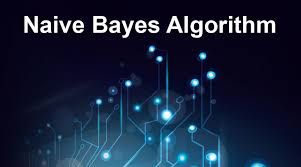

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB(var_smoothing=1e-16)
nb.fit(X_train[:,1:],y_train[:,1:].ravel())
nb_y_pred=nb.predict(X_test[:,1:])
nb_y_pred_proba = nb.predict_proba(X_test[:,1:])

In [ ]:
nb_result_df = create_result_df(nb_y_pred, y_test, nb_y_pred_proba)

In [ ]:
nb_confusion = confusion_matrix(nb_result_df['y_pred'], nb_result_df['y_test'])
plot_confussion_matrix(confusion = nb_confusion, strategy = 'Naive Bayes Classifier')
print_metrics(nb_confusion, len(y_test))

In [ ]:
nb_top_preds = nb_result_df[nb_result_df['trust']>0.9]

In [ ]:
nb2_confusion = confusion_matrix(nb_top_preds['y_pred'], nb_top_preds['y_test'])
plot_confussion_matrix(confusion = nb2_confusion, strategy = 'Naive Bayes Classifier')
print_metrics(nb2_confusion, len(y_test))

### Ensemble Voting

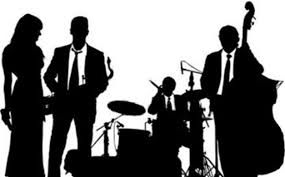

Armamos una matriz con todas las predicciones

In [ ]:
ensemble_df = pd.DataFrame()
ensemble_df['idclientecrm'] = rf2_result_df['idclientecrm']
ensemble_df['Status'] = rf2_result_df['y_test']
ensemble_df['Rf_Prediction'] = rf2_result_df['y_pred']
ensemble_df['Rf_trust'] = rf2_result_df['trust']
ensemble_df['Rf_canc_proba'] = rf2_result_df['Cancelado probability']

In [ ]:
ensemble_df = pd.merge(ensemble_df, xgb2_result_df.filter(['idclientecrm', 'y_pred', 'trust', 'Cancelado probability']), on = 'idclientecrm')

In [ ]:
ensemble_df.rename(columns={'y_pred':'xgb_Prediction', 'trust': 'xgb_trust', 'Cancelado probability':'xgb_canc_proba'}, inplace=True)

In [ ]:
ensemble_df = pd.merge(ensemble_df, nb_result_df.filter(['idclientecrm', 'y_pred', 'trust', 'Cancelado probability']), on = 'idclientecrm')

In [ ]:
ensemble_df.rename(columns={'y_pred':'nb_Prediction', 'trust':'nb_trust', 'Cancelado probability':'nb_canc_proba'}, inplace=True)

In [ ]:
ensemble_df = ensemble_df.join(pd.DataFrame(np.array(ensemble_df.iloc[:,2:])=='Cancelado').sum(axis=1).rename('Warning Level'))


In [ ]:
ensemble_df['Veredict'] = ['Cancelado' if x>= 2 else 'Vigente' for x in ensemble_df['Warning Level']]

In [ ]:
ensemble_df.head()

In [ ]:
ensemble_confusion = confusion_matrix(ensemble_df['Veredict'], ensemble_df['Status'])
plot_confussion_matrix(ensemble_confusion, strategy = 'Ensemble Classifier')
print_metrics(ensemble_confusion, len(ensemble_df))

In [ ]:
ensemble_confusion_top = confusion_matrix(ensemble_df[ensemble_df['Warning Level']==3]['Veredict'], ensemble_df[ensemble_df['Warning Level']==3]['Status'])
plot_confussion_matrix(ensemble_confusion_top, strategy='Ensemble Top Classifier')
print_metrics(ensemble_confusion_top, len(ensemble_df))

#### Con pesos basado en la confianza

In [ ]:
ensemble_df.tail()

Calculamos el Trust unánime

In [ ]:
import math

In [ ]:
col = []
for row in range(len(ensemble_df)):
    a = (np.array(ensemble_df.iloc[row,[3,6,9]])) #trust
    a = a.astype('float64') 
    b = (np.array(ensemble_df.iloc[row,[2,5,8]])=='Cancelado') #prediction
    col.append((a@b)/3) #porque hay 3 predictores
ensemble_df['Trust']= col


Calculamos Trust unánme entre Random Forest y XGBoost

In [ ]:
col = []
for row in range(len(ensemble_df)):
    a = (np.array(ensemble_df.iloc[row,[3,6]])) #trust
    a = a.astype('float64') 
    b = (np.array(ensemble_df.iloc[row,[2,5]])=='Cancelado') #prediction
    col.append((a@b)/2) #porque hay 2 predictores
ensemble_df['Trust2']= col

Calculamos Trust basado en la probabilidad de cancelado

In [ ]:
col = []
for row in range(len(ensemble_df)):
    a = (np.array(ensemble_df.iloc[row,[4,7,10]])) #canc_proba
    a = a.astype('float64') 
    b = (np.array([1,1,1])) #prediction
    col.append((a@b)/3) #porque hay 3 predictores
ensemble_df['Trust3']= col

Calculamos Trust basado en la probabilidad de cancelado, dejando de lado Naive Bayes

In [ ]:
col = []
for row in range(len(ensemble_df)):
    a = (np.array(ensemble_df.iloc[row,[4,7]])) #canc_proba
    a = a.astype('float64') 
    b = (np.array([1,1])) #prediction
    col.append((a@b)/2) #porque hay 2 predictores
ensemble_df['Trust4']= col

In [ ]:
ensemble_df.head()

In [ ]:
veredict_thresh = 0.5
ensemble_df['Veredict'] = ['Cancelado' if x>= veredict_thresh else 'Vigente' for x in ensemble_df['Trust']]
ensemble_df['Veredict2'] = ['Cancelado' if x>= veredict_thresh else 'Vigente' for x in ensemble_df['Trust2']]
ensemble_df['Veredict3'] = ['Cancelado' if x>= veredict_thresh else 'Vigente' for x in ensemble_df['Trust3']]
ensemble_df['Veredict4'] = ['Cancelado' if x>= veredict_thresh else 'Vigente' for x in ensemble_df['Trust4']]

In [ ]:
thresh = .9
ensemble_confusion_top = confusion_matrix(ensemble_df[ensemble_df['Trust']>thresh]['Veredict'], ensemble_df[ensemble_df['Trust']>thresh]['Status'])
plot_confussion_matrix(ensemble_confusion_top, strategy='Ensemble Top Classifier')
print_metrics(ensemble_confusion_top, len(ensemble_df))

In [ ]:
#top_preds = rf2_result_df[rf2_result_df['trust']>.9]
#ensemble_confusion_top = confusion_matrix(ensemble_df[ensemble_df['Trust']>thresh]['Veredict'], ensemble_df[ensemble_df['Trust']>thresh]['Status'])
N = len(y_test)
rf_prec = []
rf_pc = []
rf_recall = []
rf_size = []
xgb_prec = []
xgb_pc = []
xgb_recall = []
xgb_size = []
nb_prec = []
nb_pc = []
nb_recall = []
nb_size = []
ensemble_prec = []
ensemble_pc = []
ensemble_recall = []
ensemble_size = []
ensemble2_prec = []
ensemble2_pc = []
ensemble2_recall = []
ensemble2_size = []
ensemble3_prec = []
ensemble3_pc = []
ensemble3_recall = []
ensemble3_size = []
ensemble4_prec = []
ensemble4_pc = []
ensemble4_recall = []
ensemble4_size = []

iterations = 100
t = [0.9*x/(iterations-1) for x in range(iterations)]
for thresh in t:
    random_forest = rf2_result_df[rf2_result_df['trust']>=thresh]
    xgboost = xgb2_result_df[xgb2_result_df['trust']>=thresh]
    naive_bayes = nb_result_df[nb_result_df['trust']>=thresh]
    ensemble = ensemble_df[ensemble_df['Trust']>=thresh]
    ensemble2 = ensemble_df[ensemble_df['Trust2']>=thresh]
    ensemble3 = ensemble_df[ensemble_df['Trust3']>=thresh]
    ensemble4 = ensemble_df[ensemble_df['Trust4']>=thresh]
    
    confusion = confusion_matrix(random_forest['y_pred'], random_forest['y_test'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    rf_pc.append(p_c)
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    subset_per = 100*n/N
    rf_size.append(subset_per)
    rf_prec.append(p)
    rf_recall.append(recall)
    
    confusion = confusion_matrix(xgboost['y_pred'], xgboost['y_test'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    xgb_pc.append(p_c)
    subset_per = 100*n/N
    xgb_size.append(subset_per)
    xgb_prec.append(p)
    xgb_recall.append(recall)
    
    confusion = confusion_matrix(naive_bayes['y_pred'], naive_bayes['y_test'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    nb_pc.append(p_c)
    subset_per = 100*n/N
    nb_size.append(subset_per)
    nb_prec.append(p)
    nb_recall.append(recall)
    
    confusion = confusion_matrix(ensemble['Veredict'], ensemble['Status'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    ensemble_pc.append(p_c)
    subset_per = 100*n/N
    ensemble_size.append(subset_per)
    ensemble_prec.append(p)
    ensemble_recall.append(recall)
    
    confusion = confusion_matrix(ensemble['Veredict2'], ensemble['Status'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    ensemble2_pc.append(p_c)
    subset_per = 100*n/N
    ensemble2_size.append(subset_per)
    ensemble2_prec.append(p)
    ensemble2_recall.append(recall)
    
    confusion = confusion_matrix(ensemble['Veredict3'], ensemble['Status'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    ensemble3_pc.append(p_c)
    subset_per = 100*n/N
    ensemble3_size.append(subset_per)
    ensemble3_prec.append(p)
    ensemble3_recall.append(recall)
    
    confusion = confusion_matrix(ensemble['Veredict4'], ensemble['Status'])
    n = confusion.sum()
    p = (confusion[0][0]+confusion[1][1])/n
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    ensemble4_pc.append(p_c)
    subset_per = 100*n/N
    ensemble4_size.append(subset_per)
    ensemble4_prec.append(p)
    ensemble4_recall.append(recall)



In [ ]:
ax1 = plt.plot(t, rf_prec, label = 'Random Forest' )
ax2 = plt.plot(t, xgb_prec, label = 'XGBoost')
ax3 = plt.plot(t, nb_prec, label = 'Naive Bayes')
ax4 = plt.plot(t, ensemble_prec, label = 'Ensemble', linestyle = 'dashed')
ax5 = plt.plot(t, ensemble2_prec, label = 'Ensemble RF + XGB', linestyle = 'dashed')
ax6 = plt.plot(t, ensemble3_prec, label = 'Ensemble Alt', linestyle = 'dashed')
ax7 = plt.plot(t, ensemble4_prec, label = 'Ensemble Alt RF + XGB', linestyle = 'dashed')
plt.title('Accuracy for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
ax1 = plt.plot(t, rf_pc, label = 'Random Forest' )
ax2 = plt.plot(t, xgb_pc, label = 'XGBoost')
ax3 = plt.plot(t, nb_pc, label = 'Naive Bayes')
ax4 = plt.plot(t, ensemble_pc, label = 'Ensemble', linestyle = 'dashed')
ax5 = plt.plot(t, ensemble2_pc, label = 'Ensemble RF + XGB', linestyle = 'dashed')
ax6 = plt.plot(t, ensemble3_pc, label = 'Ensemble Alt', linestyle = 'dashed')
ax7 = plt.plot(t, ensemble4_pc, label = 'Ensemble Alt RF + XGB', linestyle = 'dashed')
plt.title('Accuracy on Cancelado for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [ ]:
ax1 = plt.plot(t, rf_recall, label = 'Random Forest')
ax2 = plt.plot(t, xgb_recall, label = 'XGBoost')
ax3 = plt.plot(t, nb_recall, label = 'Naive Bayes')
ax4 = plt.plot(t, ensemble_recall, label = 'Ensemble', linestyle = 'dashed')
ax5 = plt.plot(t, ensemble2_recall, label = 'Ensemble RF + XGB', linestyle = 'dashed')
ax6 = plt.plot(t, ensemble3_recall, label = 'Ensemble Alt', linestyle = 'dashed')
ax7 = plt.plot(t, ensemble4_recall, label = 'Ensemble Alt RF + XGB', linestyle = 'dashed')
plt.title('Recall for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()

In [ ]:
ax1 = plt.plot(t, rf_size, label = 'Random Forest')
ax2 = plt.plot(t, xgb_size, label = 'XGBoost')
ax3 = plt.plot(t, nb_size, label = 'Naive Bayes')
ax4 = plt.plot(t, ensemble_size, label = 'Ensemble', linestyle = 'dashed')
ax5 = plt.plot(t, ensemble2_size, label = 'Ensemble RF + XGB', linestyle = 'dashed')
ax6 = plt.plot(t, ensemble3_size, label = 'Ensemble Alt', linestyle = 'dashed')
ax7 = plt.plot(t, ensemble4_size, label = 'Ensemble Alt RF + XGB', linestyle = 'dashed')
plt.title('Subset size for different models', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Subset size')
plt.legend()
plt.grid()
plt.show()

### Corte por tamaño de empresa

In [138]:
xgb2_result_df.head()

NameError: name 'xgb2_result_df' is not defined

In [ ]:
data.filter(['idclientecrm', 'CLIENTE GRUPO', 'Status Cliente']).head()

In [ ]:
xgb2_result_df = pd.merge(xgb2_result_df, data.filter(['idclientecrm', 'CLIENTE GRUPO', 'Status Cliente']), on = 'idclientecrm')

In [ ]:
xgb2_result_df_big = xgb2_result_df[xgb2_result_df['CLIENTE GRUPO'] == '1']
xgb2_result_df_small = xgb2_result_df[xgb2_result_df['CLIENTE GRUPO'] != '1']

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
Label = ['Big Clients', 'Small Clients']
clients = [len(xgb2_result_df_big), len(xgb2_result_df_small)]
ax.pie(clients, labels = Label,autopct='%1.2f%%')
#plt.title(, fontweight="bold")
plt.show()

In [ ]:
confusion = confusion_matrix(xgb2_result_df_big['y_pred'], xgb2_result_df_big['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost (Big Clients)')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top_big = xgb2_result_df_big[xgb2_result_df_big['trust']>0.75]
confusion = confusion_matrix(xgb2_top_big['y_pred'], xgb2_top_big['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost (Big Clients)')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top_big = xgb2_result_df_big[xgb2_result_df_big['trust']>0.9]
confusion = confusion_matrix(xgb2_top_big['y_pred'], xgb2_top_big['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost (Big Clients)')
print_metrics(confusion, len(y_test))

In [ ]:
confusion = confusion_matrix(xgb2_result_df_small['y_pred'], xgb2_result_df_small['y_test'])

In [ ]:
plot_confussion_matrix(confusion, strategy = 'XGBoost (Small Clients)')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top_small = xgb2_result_df_small[xgb2_result_df_small['trust']>0.75]
confusion = confusion_matrix(xgb2_top_small['y_pred'], xgb2_top_small['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost (Small Clients)')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top_small = xgb2_result_df_small[xgb2_result_df_small['trust']>0.9]
confusion = confusion_matrix(xgb2_top_small['y_pred'], xgb2_top_small['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost (Small Clients)')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top = xgb2_result_df[xgb2_result_df['trust']>0.9]
confusion = confusion_matrix(xgb2_top['y_pred'], xgb2_top['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost Classifier')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top = xgb2_result_df[xgb2_result_df['trust']>0.75]
confusion = confusion_matrix(xgb2_top['y_pred'], xgb2_top['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost Classifier')
print_metrics(confusion, len(y_test))

In [ ]:
xgb2_top = xgb2_result_df
confusion = confusion_matrix(xgb2_result_df['y_pred'], xgb2_result_df['y_test'])
plot_confussion_matrix(confusion, strategy = 'XGBoost Classifier')
print_metrics(confusion, len(y_test))

In [ ]:
len(xgb2_result_df), len(xgb2_result_df_big)+len(xgb2_result_df_small)

In [ ]:
iterations = 100
total_pc = []
small_pc = []
big_pc = []
total_recall = []
small_recall = []
big_recall = []

t = [0.9*x/(iterations-1) for x in range(iterations)]
for thresh in t:
    xgboost = xgb2_result_df[xgb2_result_df['trust']>thresh]
    small = xgb2_result_df_small[xgb2_result_df_small['trust']>thresh]
    big = xgb2_result_df_big[xgb2_result_df_big['trust']>thresh]
    
    confusion = confusion_matrix(xgboost['y_pred'], xgboost['y_test'])
    n = confusion.sum()
    #p = (confusion[0][0]+confusion[1][1])/n
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    total_pc.append(p_c)
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    #subset_per = 100*n/N
    #rf_size.append(subset_per)
    #rf_prec.append(p)
    total_recall.append(recall)
    
    confusion = confusion_matrix(small['y_pred'], small['y_test'])
    n = confusion.sum()
    #p = (confusion[0][0]+confusion[1][1])/n
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    small_pc.append(p_c)
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    #subset_per = 100*n/N
    #rf_size.append(subset_per)
    #rf_prec.append(p)
    small_recall.append(recall)
    
    confusion = confusion_matrix(big['y_pred'], big['y_test'])
    n = confusion.sum()
    #p = (confusion[0][0]+confusion[1][1])/n
    p_c = confusion[0][0]/(confusion[0][0]+confusion[1][0])
    big_pc.append(p_c)
    recall = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    #subset_per = 100*n/N
    #rf_size.append(subset_per)
    #rf_prec.append(p)
    big_recall.append(recall)

In [ ]:
ax1 = plt.plot(t, total_recall, label = 'Todos los datos')
ax2 = plt.plot(t, small_recall, label = 'Clientes Small')
ax3 = plt.plot(t, big_recall, label = 'Clientes Big')

plt.title('Recall', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.show()

In [ ]:
ax1 = plt.plot(t, total_pc, label = 'Todos los datos')
ax2 = plt.plot(t, small_pc, label = 'Clientes Small')
ax3 = plt.plot(t, big_pc, label = 'Clientes Big')

plt.title('Accuracy on Cancelado', fontweight="bold")
plt.xlabel('Trust threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [76]:
data.head()

,pais,ano_alta,idclientecrm,tipo_cliente,CLIENTE GRUPO,Status Cliente,Monto_total 2018,ARPA (rev prom),Lead Venta Formulario,Lead Venta Ver Dato,...,User vendedor,Equipo,Provincia,Lead Venta,Lead Alquiler,Lead Alquiler temporal,CP Lead Venta,CP Lead Alquiler,CP Lead Alquiler temporal,Status Cliente Num
1,Brasil,2018,10400005,Small,0.0,Vigente,3982.0,332.000,20.0,18.0,...,rodrigoserpa,Distrito Federal - Farmers,Distrito Federal,38.0,200.0,0.0,420.0,97.0,7964.0,0
2,Brasil,2018,10400007,Small,0.0,Vigente,2871.0,239.000,93.0,110.0,...,jaquelinelopes@wimoveiscom,Distrito Federal - Farmers,Distrito Federal,203.0,435.0,0.0,57.0,26.0,5742.0,0
3,Brasil,2018,10400010,Big,1.0,Cancelado,13530.0,1.353,184.0,123.0,...,juliana@wimoveiscom,Distrito Federal - Farmers,Distrito Federal,307.0,1004.0,0.0,184.0,57.0,27060.0,1
4,Brasil,2018,10400013,Small,0.0,Vigente,1790.0,179.000,1.0,0.0,...,patricia@wimoveiscom,Distrito Federal - Farmers,Distrito Federal,1.0,5.0,0.0,3580.0,1492.0,3580.0,0
5,Brasil,2018,10400014,Big,1.0,Vigente,16188.0,1.349,181.0,107.0,...,rodrigoserpa,Distrito Federal - Farmers,Distrito Federal,288.0,2392.0,0.0,240.0,27.0,32376.0,0


In [79]:
min(data['Monto_total 2018']), max(data['Monto_total 2018']) 

(10.0, 807500.0)

In [81]:
bin_labels_5 = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']
data['quantile_ex_3'] = pd.qcut(data['Monto_total 2018'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels_5)
data.head()

,pais,ano_alta,idclientecrm,tipo_cliente,CLIENTE GRUPO,Status Cliente,Monto_total 2018,ARPA (rev prom),Lead Venta Formulario,Lead Venta Ver Dato,...,Equipo,Provincia,Lead Venta,Lead Alquiler,Lead Alquiler temporal,CP Lead Venta,CP Lead Alquiler,CP Lead Alquiler temporal,Status Cliente Num,quantile_ex_3
1,Brasil,2018,10400005,Small,0.0,Vigente,3982.0,332.000,20.0,18.0,...,Distrito Federal - Farmers,Distrito Federal,38.0,200.0,0.0,420.0,97.0,7964.0,0,Platinum
2,Brasil,2018,10400007,Small,0.0,Vigente,2871.0,239.000,93.0,110.0,...,Distrito Federal - Farmers,Distrito Federal,203.0,435.0,0.0,57.0,26.0,5742.0,0,Platinum
3,Brasil,2018,10400010,Big,1.0,Cancelado,13530.0,1.353,184.0,123.0,...,Distrito Federal - Farmers,Distrito Federal,307.0,1004.0,0.0,184.0,57.0,27060.0,1,Diamond
4,Brasil,2018,10400013,Small,0.0,Vigente,1790.0,179.000,1.0,0.0,...,Distrito Federal - Farmers,Distrito Federal,1.0,5.0,0.0,3580.0,1492.0,3580.0,0,Gold
5,Brasil,2018,10400014,Big,1.0,Vigente,16188.0,1.349,181.0,107.0,...,Distrito Federal - Farmers,Distrito Federal,288.0,2392.0,0.0,240.0,27.0,32376.0,0,Diamond


In [82]:
rate = pd.DataFrame()
rate['quantile_ex_3'] = data['quantile_ex_3'].unique()

In [83]:
rate

,quantile_ex_3
0,Platinum
1,Diamond
2,Gold
3,Bronze
4,Silver


In [85]:
a = []
for q in rate['quantile_ex_3']:
    r = len(data[data['quantile_ex_3']==q])/len(data)
    a.append(r)
rate['rate'] = a

In [86]:
rate

,quantile_ex_3,rate
0,Platinum,0.200114
1,Diamond,0.199546
2,Gold,0.200327
3,Bronze,0.200256
4,Silver,0.199759
